# PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS
##  Pós-graduação Lato Sensu em Ciência de Dados e Big Data 

## ANÁLISE TEMPORAL DA GESTÃO DE ESGOTOS EM GOIÁS (1992-2021) E PERSPECTIVAS FUTURAS (2022-2032)

### ADENILSON ALVES DA SILVA - 2023

# D - Criação de Modelos de Machine Learning

Versão Python: 3.11.4

Realizar as seguintes instalações:
- pip install pandas==1.3.4
- pip install matplotlib==3.4.3
- pip install statsmodels==0.12.2
- pip install Numpy==1.23.5
- pip install tabulate==0.9.0
- pip install pyclustering==0.10.1.2

####  1 - Importando bibliotecas

In [1]:
import pandas as pd  # Biblioteca para trabalhar com dados em formato de tabela (DataFrame)
import matplotlib.pyplot as plt  # Biblioteca para criação de gráficos
import numpy as np  # Biblioteca para manipulação de arrays numéricos
import matplotlib.gridspec as gridspec  # Biblioteca para criação de layouts de gráficos personalizados
import itertools  # Biblioteca para iteração eficiente
import random  # Biblioteca para geração de números aleatórios
import seaborn as sns  # Biblioteca para visualização de dados baseada no Matplotlib
import os  # Usada para lidar com operações do sistema de arquivos
import joblib # Biblioteca para salvar e carregar modelos e objetos Python

from statsmodels.tsa.arima_model import ARIMA  # Importa o modelo ARIMA para análise de séries temporais
from statsmodels.tsa.arima.model import ARIMA  # Importa o modelo ARIMA para análise de séries temporais
from sklearn.linear_model import LinearRegression  # Importa o modelo de regressão linear
from sklearn.model_selection import cross_val_score  # Importa função para validação cruzada
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit #
from tabulate import tabulate  # Biblioteca para formatar tabelas
from scipy import stats # Importa o módulo scipy.stats para estatísticas

import warnings  # Biblioteca para controle de avisos durante a execução do código
warnings.filterwarnings('ignore')  # Suprime avisos

#### 2 -  Obtendo todos os dados tratados


In [2]:
# Gerando o Dataframe com a série histórica da coleta e tratamento de esgotos dos municipios de Goiás
df = pd.read_csv('dados_GO/B - dado_tratado/df_municipios_habitantes_saneamento_codigo.csv', 
                delimiter = ';',
                encoding = 'utf-8',
                index_col= False)

# Ordenando o DataFrame df por Município e Ano
df = df.sort_values(['Município', 'Ano'])

# Visualizando os primeiros 5 registros do Dataframe
df.head()

,Código do Município (IBGE),Município,Ano,População Total Urbana,Volume de esgoto produzido - 1000 m³,Volume de esgotos coletado - 1000 m³,Volume de esgotos tratado - 1000 m³
0,5200050.0,Abadia de Goiás,1992,0,0.00,0.0,0.0
246,5200050.0,Abadia de Goiás,1993,0,0.00,0.0,0.0
492,5200050.0,Abadia de Goiás,1994,0,0.00,0.0,0.0
738,5200050.0,Abadia de Goiás,1995,0,0.00,0.0,0.0
6396,5200050.0,Abadia de Goiás,1996,1560,74.02,0.0,0.0


In [3]:
# Criando um DataFrame 'df_go' que agrupa a população urbana por ano
df_go = pd.DataFrame(df.groupby('Ano')['Volume de esgoto produzido - 1000 m³', 
                                        'Volume de esgotos coletado - 1000 m³',
                                        'Volume de esgotos tratado - 1000 m³'].sum()).reset_index()


# Exibindo as primeiras linhas do DataFrame 'df_ano'
df_go.head()

,Ano,Volume de esgoto produzido - 1000 m³,Volume de esgotos coletado - 1000 m³,Volume de esgotos tratado - 1000 m³
0,1992,175585.65,0.0,0.0
1,1993,178712.42,0.0,0.0
2,1994,181682.00,0.0,0.0
3,1995,184578.25,0.0,0.0
4,1996,191674.24,9285.6,7365.7


#### 3 -  Criando as variáveis e métodos que serão usados nos modelos

In [4]:
# Filtrando o DataFrame para anos maiores que 1996
# Será usado nas previsões das features 'Volume de esgotos coletado - 1000 m³' e 'Volume de esgotos tratado - 1000 m³'
df_filtered = df_go[df_go['Ano'] > 1996]

# Definindo nomes das colunas relevantes
nome_coluna_produzido = 'Volume de esgoto produzido - 1000 m³'
nome_coluna_coletado = 'Volume de esgotos coletado - 1000 m³'
nome_coluna_tratado = 'Volume de esgotos tratado - 1000 m³'
nome_coluna_municipio = 'Município'
nome_coluna_ano = 'Ano'

# Separando as variáveis independentes e dependentes para análises futuras
X1 = df_go[nome_coluna_ano]
X2 = df_filtered[nome_coluna_ano] 

y1 = df_go[nome_coluna_produzido]
y2 = df_filtered[nome_coluna_coletado]
y3 = df_filtered[nome_coluna_tratado]

# Definindo nomes das colunas para clusters 
nome_coluna_cluster_produzido = 'Cluster_produzido'
nome_coluna_cluster_coletado = 'Cluster_coletado'
nome_coluna_cluster_tratado = 'Cluster_tratado'

# Pivotando o DataFrame para análises futuras
# Será usado na clusterização
df_pivot_produzido = df.pivot(index=nome_coluna_municipio, columns=nome_coluna_ano, values=nome_coluna_produzido)
df_pivot_coletado = df.pivot(index=nome_coluna_municipio, columns=nome_coluna_ano, values=nome_coluna_coletado)
df_pivot_tratado = df.pivot(index=nome_coluna_municipio, columns=nome_coluna_ano, values=nome_coluna_tratado)

# Estabelecendo uma faixa de anos futuros
anos_futuros = np.arange(2022, 2033).reshape(-1, 1)


In [5]:
def aplicar_metodo_cotovelo(df, num_clusters_range = range(1, 11)):
    # Copiando o DataFrame para evitar modificações no original
    df = df.copy()
    
    # Normalizando os dados usando o StandardScaler
    scaler = StandardScaler()
    df_normalizado = scaler.fit_transform(df)
    
    # Definindo uma semente (SEED) para tornar os resultados reprodutíveis
    SEED = 121
    
    # Inicializando uma lista para armazenar os valores de inércia
    valores_inercia = []
    
    # Iterando sobre o número de clusters especificado
    for num_clusters in num_clusters_range:
        # Criando um modelo K-Means com o número de clusters atual
        kmeans = KMeans(n_clusters=num_clusters, random_state=SEED)
        
        # Atribuindo cada ponto de dados a um cluster e calculando a inércia
        df['Cluster'] = kmeans.fit_predict(df_normalizado)
        valores_inercia.append(kmeans.inertia_)   
        
    # Retornando os valores de inércia e a faixa de números de clusters
    return valores_inercia, num_clusters_range




def aplicar_modelo_kmeans(df, num_clusters):
    # Copiando o DataFrame para evitar modificações no original
    df = df.copy()
    
    # Normalizando os dados usando o StandardScaler
    scaler = StandardScaler()
    df_cluster_normalizado = scaler.fit_transform(df)
    
    # Definindo uma semente (SEED) para tornar os resultados reprodutíveis
    SEED = 121
    
    # Criando um modelo K-Means com o número de clusters especificado
    kmeans = KMeans(n_clusters=num_clusters, random_state=SEED)
    
    # Atribuindo cada ponto de dados a um cluster e armazenando em um dicionário
    df['Cluster'] = kmeans.fit_predict(df_cluster_normalizado)
    dicionario = df.to_dict()['Cluster']
    
    # Retornando o dicionário com atribuições de cluster
    return dicionario




def definir_cor_aleatoria():
    # Gerando valores aleatórios para os canais de cor (vermelho, verde e azul).
    red = random.randint(0, 200)
    green = random.randint(0, 200)
    blue = random.randint(0, 200)
    
    # Criando uma representação hexadecimal da cor combinando os canais de cor.
    cor = "#{:02x}{:02x}{:02x}".format(red, green, blue)
    
    # Retornando a cor gerada no formato "#RRGGBB".
    return cor




def plotar_grafico_simples(x, y, titulo, rotulo_x, rotulo_y):
    # Gerando uma cor aleatória para o gráfico
    cor = definir_cor_aleatoria()
    
    # Criando uma figura para o gráfico com tamanho específico
    plt.figure(figsize=(12, 8))  
    
    # Plotando os dados no gráfico usando marcadores, linha e a cor aleatória
    plt.plot(x, y, marker='o', linestyle='-', color=cor)  
    
    # Adicionando um título ao gráfico
    plt.title(titulo) 
    
    # Adicionando rótulos aos eixos X e Y
    plt.xlabel(rotulo_x) 
    plt.ylabel(rotulo_y)  
    
    # Ativando a grade no gráfico
    plt.grid(True) 
    
    # Exibindo o gráfico
    plt.show()
  


    
def plotar_unico_grafico_multi_curvas(x_values, y_values, titulo, rotulo, eixos):
    # Criando uma figura para o gráfico com tamanho específico
    plt.figure(figsize=(12, 8)) 
    
    # Iterando sobre as curvas para plotar cada uma com uma cor aleatória e rótulo
    for i in range(len(x_values)):
        cor = definir_cor_aleatoria()
        plt.plot(x_values[i], y_values[i], color=cor, label=rotulo[i])
    
    # Adicionando um título ao gráfico
    plt.title(titulo) 
    
    # Adicionando rótulos aos eixos X e Y
    plt.xlabel(eixos[0]) 
    plt.ylabel(eixos[1])  
    
    # Adicionando uma legenda para as curvas
    plt.legend()
    
    # Ativando a grade no gráfico
    plt.grid(True)  
    
    # Exibindo o gráfico
    plt.show()


    
    
def plotar_graficos_multiplos(df, coluna_grupo, x, y, linhas, separar_por):
    # Obtendo os valores únicos que serão usados para separar os dados
    separador = df[separar_por].unique()
    
    # Iterando sobre os valores de separação
    for valor in separador:
        # Filtrando o DataFrame com base no valor de separação
        df_filtrado = df[df[separar_por] == valor]
        
        # Obtendo os valores únicos da coluna de agrupamento
        coluna_grupo_unico = df_filtrado[coluna_grupo].unique()
        
        # Gerando uma cor aleatória para cada conjunto de dados
        cor = definir_cor_aleatoria()
        
        # Imprimindo o valor atual de separação
        print(separar_por +': '+ str(valor))
        
        # Calculando o número de linhas necessário para os subplots
        num_linhas = int(np.ceil(len(coluna_grupo_unico) / linhas))
        
        # Iterando sobre as linhas de subplots
        for linha in range(num_linhas):
            # Selecionando o grupo de colunas para esta linha de subplots
            coluna_grupo_linha = coluna_grupo_unico[linha * linhas:(linha + 1) * linhas]
            
            # Criando uma figura para os subplots
            plt.figure(figsize=(20, 3))
            
            # Iterando sobre as colunas dentro da linha de subplots
            for i, coluna_unico_grupo in enumerate(coluna_grupo_linha):
                # Selecionando os dados para o grupo atual
                df_unico_grupo = df_filtrado[df_filtrado[coluna_grupo] == coluna_unico_grupo]
                
                # Criando um subplot na posição atual
                plt.subplot(1, linhas, i + 1)
                
                # Plotando os dados
                plt.plot(df_unico_grupo[x], df_unico_grupo[y], color=cor)
                
                # Definindo os rótulos e títulos dos subplots
                plt.xticks([]) 
                plt.yticks([]) 
                titulo_quebrado = '\n'.join(coluna_unico_grupo.split())
                plt.title(f'{titulo_quebrado}')
                plt.xlabel(x)
                plt.ylabel(y)
            
            # Ajustando o layout dos subplots para melhor exibição
            plt.tight_layout()
            
            # Exibindo os subplots
            plt.show()
            
            # Fechando a figura atual
            plt.close()
            

            
            
def validar_cruzadamente(cv, X, y):
    # Criando uma instância de modelo de regressão linear
    modelo = LinearRegression()
    
    # Realizando validação cruzada e obtendo pontuações de erro quadrático médio negativo
    scores = cross_val_score(modelo, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    # Mantendo os valores negativos do erro quadrático médio (os valores são negativos por padrão)
    mse_scores = -scores
    
    # Calculando a média dos valores do erro quadrático médio
    mean_mse = mse_scores.mean()
    
    # Retornando a média do erro quadrático médio e o modelo treinado
    return mean_mse, modelo




def medir_desempenho_grau_regressao_polinomial(X, y, cv=5, graus=list(range(1, 11))):
    # Lista para armazenar as métricas de desempenho
    desempenho = []
    
    # Iterando sobre os diferentes graus de polinômios
    for grau in graus:
        # Criando recursos polinomiais com o grau especificado
        poly_features = PolynomialFeatures(degree=grau)
        X_poly = poly_features.fit_transform(X) 
        
        # Medindo o desempenho do modelo com validação cruzada
        mean_mse, modelo = validar_cruzadamente(cv, X_poly, y)
        
        # Treinando o modelo
        modelo.fit(X_poly, y)
        
        # Fazendo previsões
        y_pred = modelo.predict(X_poly)
        
        # Calculando o coeficiente de determinação (R²)
        r_squared = r2_score(y, y_pred)
        
        # Armazenando as métricas de desempenho em uma lista
        desempenho.append(f'Grau:{grau}, \
        Raiz do Erro Quadrático Médio (RMSE):{np.sqrt(mean_mse).round(2)},\
        R²:{r_squared.round(6)}')
    
    return desempenho




def aplicar_regressao_polinomial(X, y, graus):
    # Criando instância do objeto PolynomialFeatures com o grau especificado
    feature_poli = PolynomialFeatures(degree=graus)
    
    # Transformando os recursos de entrada em recursos polinomiais
    X_poly = feature_poli.fit_transform(X.values.reshape(-1, 1))
    
    # Criando um modelo de regressão linear
    modelo = LinearRegression()
    
    # Treinando o modelo com os recursos polinomiais e os valores de saída
    modelo.fit(X_poly, y)
    
    # Fazendo previsões usando o modelo treinado
    y_pred = modelo.predict(X_poly)
    
    # Retornando as previsões, o modelo treinado e o objeto PolynomialFeatures
    return y_pred, modelo, feature_poli




def aplicar_regressao_linear(X, y, cv=5):
    # Calculando o erro médio quadrático médio e obtendo o modelo através de validação cruzada
    mean_mse, modelo = validar_cruzadamente(cv, X.values.reshape(-1, 1), y)
    
    # Treinando o modelo linear com os dados de entrada e saída
    modelo.fit(X.values.reshape(-1, 1), y)
    
    # Realizando previsões com o modelo treinado
    y_pred = modelo.predict(X.values.reshape(-1, 1))
    
    # Calculando o coeficiente de determinação R² para avaliar o modelo
    r_squared = r2_score(y, y_pred)
  
    # Retornando as previsões, o modelo, o erro médio quadrático médio e o R²
    return y_pred, modelo, mean_mse, r_squared




def medir_desempenho_ARIMA(X, y, p_values=range(0, 2), d_values=range(0, 2), q_values=range(0, 2)):
    # Criando uma série temporal a partir dos dados de entrada
    serie_temporal = pd.Series(y)
    serie_temporal.index = X
    
    # Lista para armazenar as métricas de desempenho para diferentes combinações de p, d e q
    desempenho = []
    
    # Iterando através de todas as combinações de p, d e q
    for p, d, q in itertools.product(p_values, d_values, q_values):
        # Configurando a validação cruzada em séries temporais com 5 splits
        tscv = TimeSeriesSplit(n_splits=5)
        mse_scores = []  # Lista para armazenar os valores do erro quadrático médio
        r_squared_scores = []  # Lista para armazenar os valores do coeficiente de determinação (R²)
        
        # Iterando através dos splits da validação cruzada
        for train_idx, test_idx in tscv.split(serie_temporal):
            train_fold, test_fold = serie_temporal.iloc[train_idx], serie_temporal.iloc[test_idx]
            
            # Treinando o modelo ARIMA
            model_arima = ARIMA(train_fold, order=(p, d, q))
            model_arima_fit = model_arima.fit()
            
            # Realizando previsões com base no modelo treinado
            predictions = model_arima_fit.forecast(steps=len(test_fold))
            
            # Calculando o erro quadrático médio
            mse = mean_squared_error(test_fold, predictions)
            mse_scores.append(mse)
            
            # Calculando o coeficiente de determinação (R²)
            r_squared = r2_score(test_fold, predictions)
            r_squared_scores.append(r_squared)
        
        # Calculando as métricas médias para esta combinação de p, d e q
        avg_mse = np.mean(mse_scores)
        avg_r_squared = np.mean(r_squared_scores)
        
        # Armazenando as métricas de desempenho na lista
        desempenho.append(f'(p={p}; d={d}; q={q}), \
AIC: {model_arima_fit.aic.round(2)}, \
Raiz do Erro Quadrático Médio: {np.sqrt(avg_mse).round(2)}, \
Coeficiente de Determinação (R²): {avg_r_squared.round(6)}')
    
    # Retornando as métricas de desempenho para diferentes combinações de p, d e q
    return desempenho


# Criando um DataFrame para análise estatística
def calcular_p_value_alpha_05(x, y_real, y_pred):
    df_teste_p_valor = pd.DataFrame({'Ano': x, 'Valor Real': y_real, 'Valor Previsto': y_pred})
    
    # Calculando a diferença entre os valores previstos e reais
    df_teste_p_valor['Diferença'] = df_teste_p_valor['Valor Previsto'] - df_teste_p_valor['Valor Real']
    
    # Realizando o teste t de amostras pareadas
    t_statistic, p_valor = stats.ttest_rel(df_teste_p_valor['Valor Previsto'], 
                                       df_teste_p_valor['Valor Real'])
    
    # Definindo o nível de significância (alpha)
    alpha = 0.05  
    
    # Verificando se a diferença é estatisticamente significativa
    if p_valor < alpha:
        print(f"Diferença estatisticamente significativa (p_value:{p_valor.round(8)})")
    else:
        print(f"Não há diferença estatisticamente significativa (p_value:{p_valor.round(8)})")



#### 3 -  Clusterizando os municípios de Goiás

Método do Cotovelo para Determinar o Número de Cluster(s)


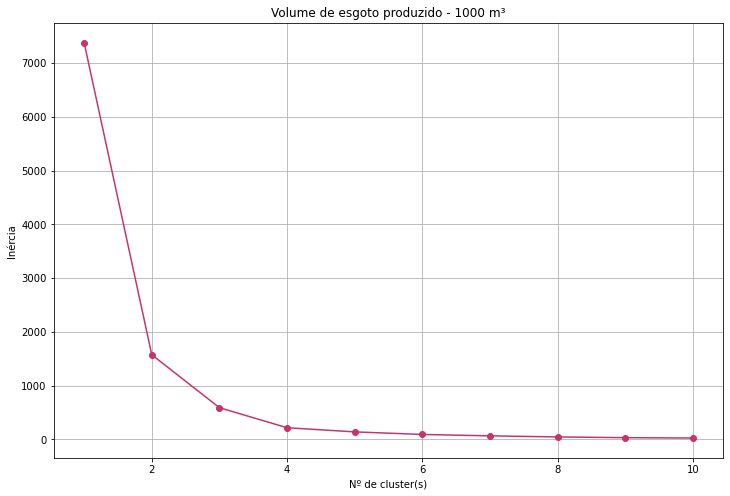

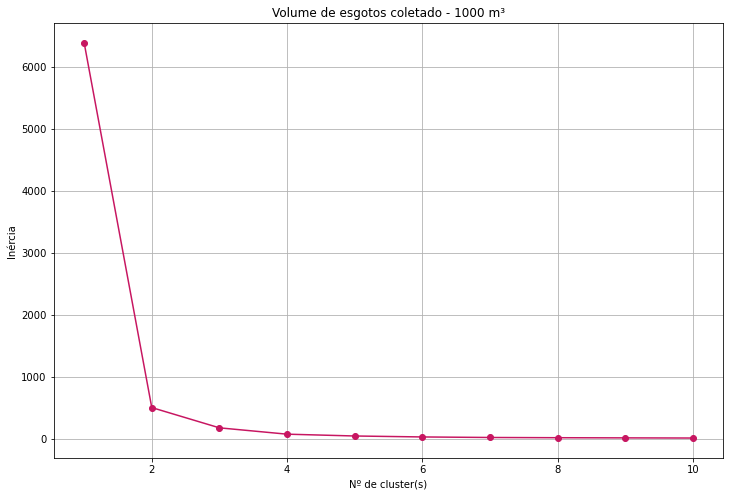

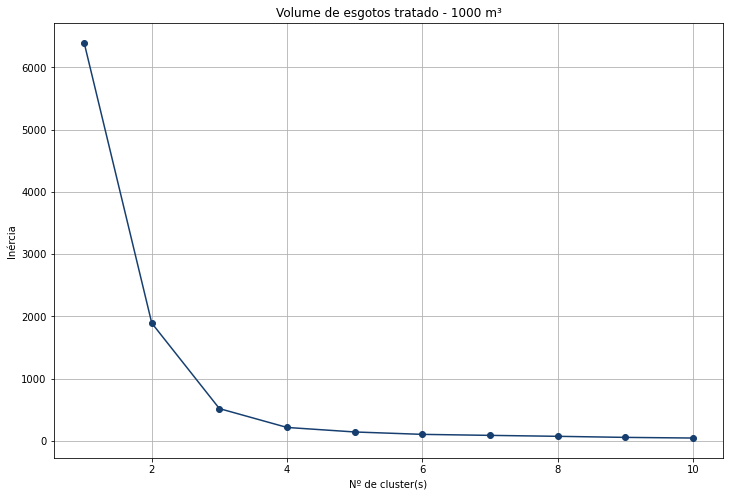

In [6]:
# Aplicando o Método Elbow Curve (método do cotovelo) em cada feature para encontrar a quantidade ideal de clusters K
inercia_produzido, cluster_produzido = aplicar_metodo_cotovelo(df_pivot_produzido)
inercia_coletado, cluster_coletado = aplicar_metodo_cotovelo(df_pivot_coletado)
inercia_tratado, cluster_tratado = aplicar_metodo_cotovelo(df_pivot_tratado)

# Plotando o gráfico com os dados obtidos por intermédio do Método Elbow Curve (método do cotovelo) 
print('Método do Cotovelo para Determinar o Número de Cluster(s)')
plotar_grafico_simples(cluster_produzido, inercia_produzido, nome_coluna_produzido, 'Nº de cluster(s)', 'Inércia')
plotar_grafico_simples(cluster_coletado, inercia_coletado, nome_coluna_coletado, 'Nº de cluster(s)', 'Inércia')
plotar_grafico_simples(cluster_tratado, inercia_tratado, nome_coluna_tratado, 'Nº de cluster(s)', 'Inércia')

Clusterização: Volume de esgoto produzido - 1000 m³
Cluster_produzido: 0


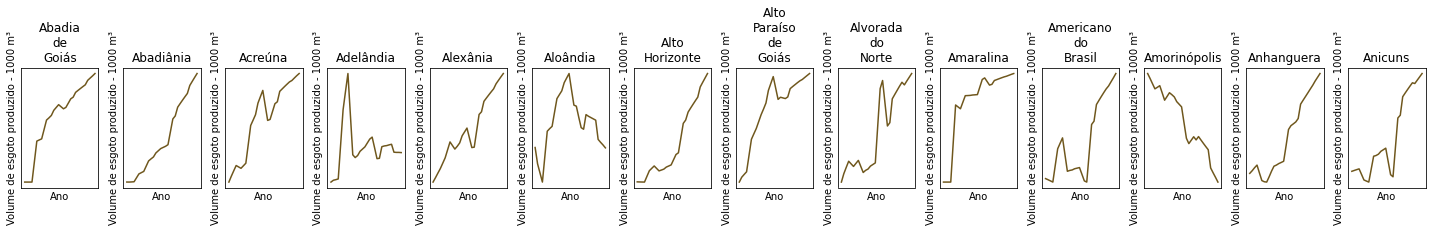

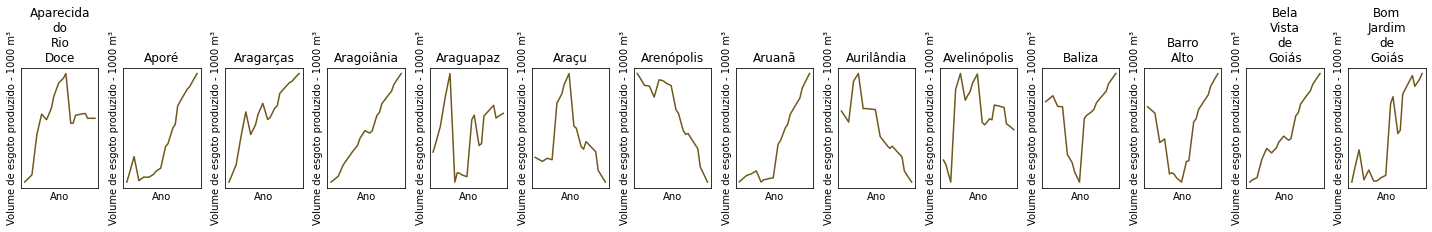

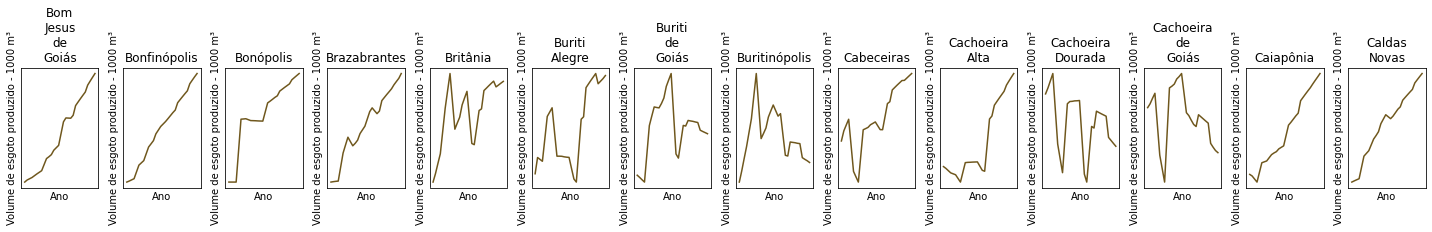

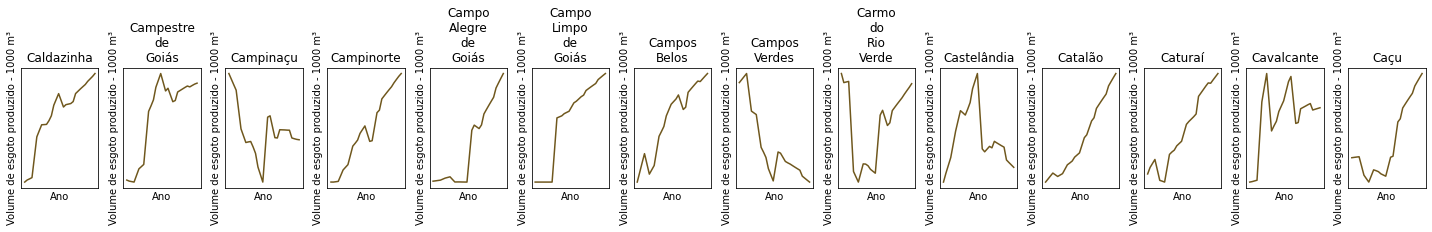

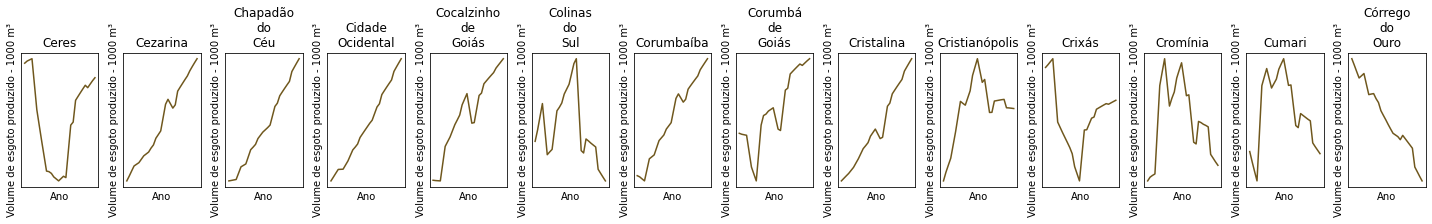

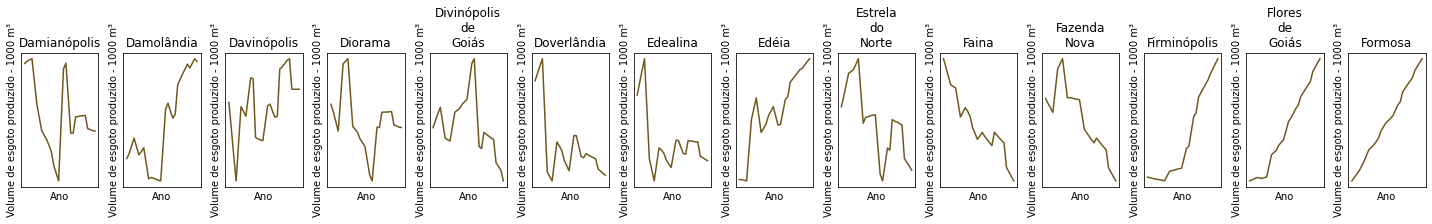

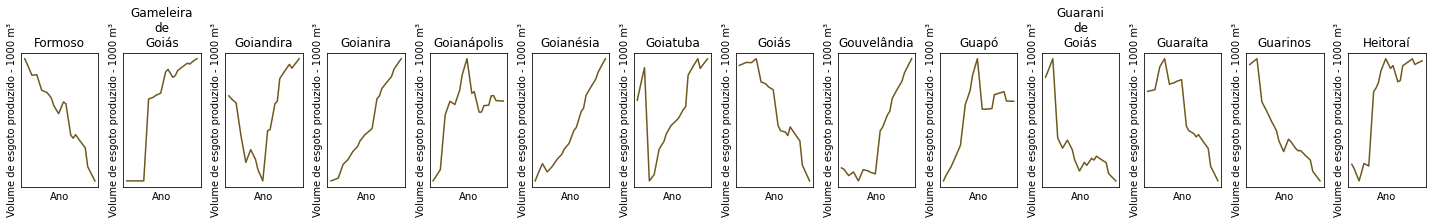

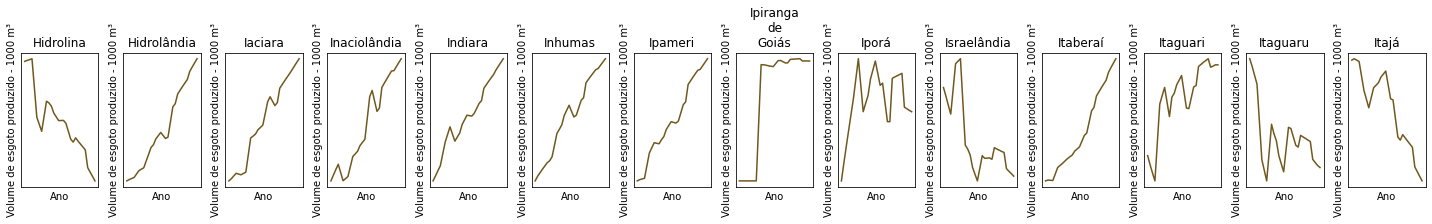

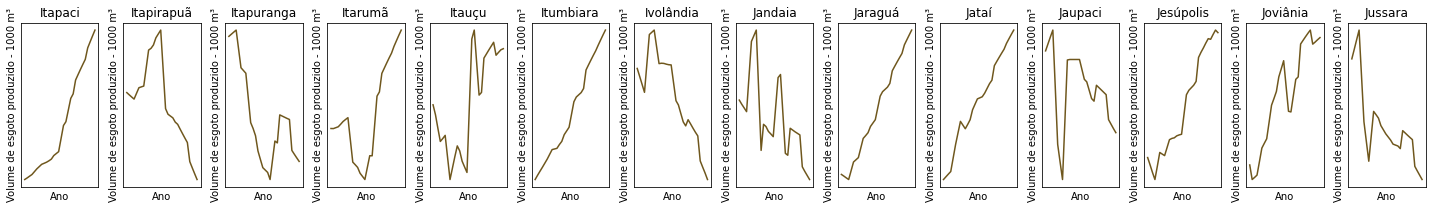

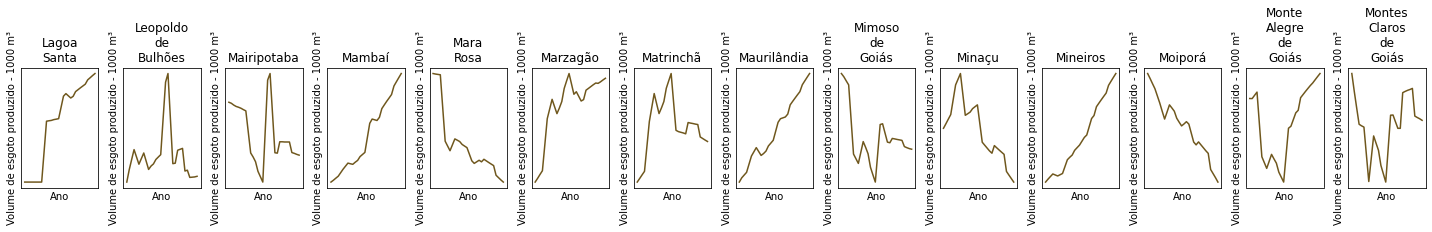

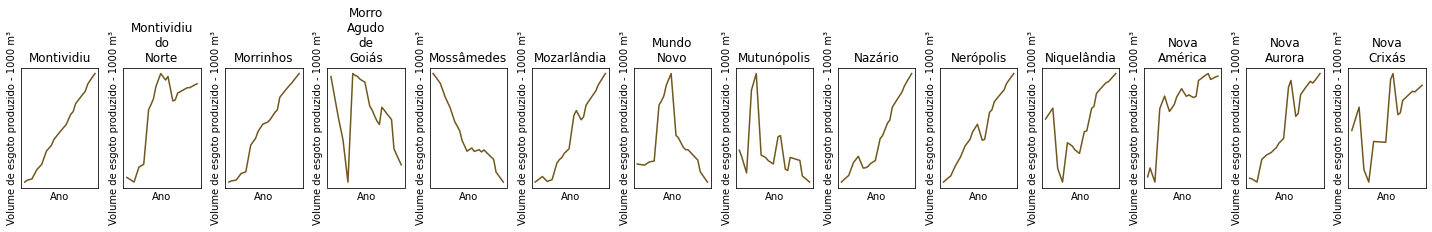

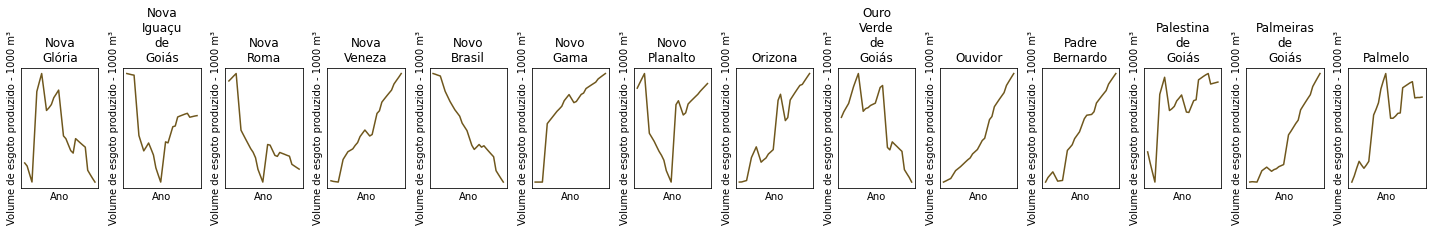

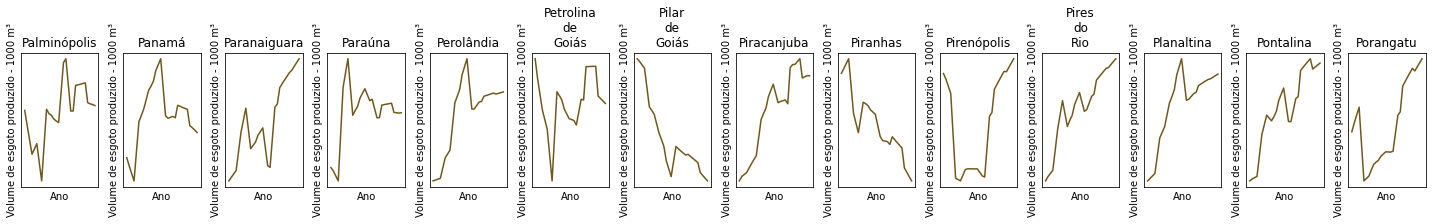

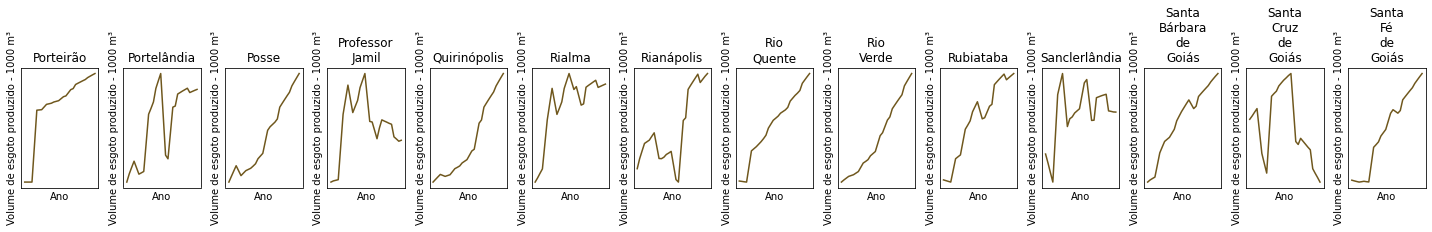

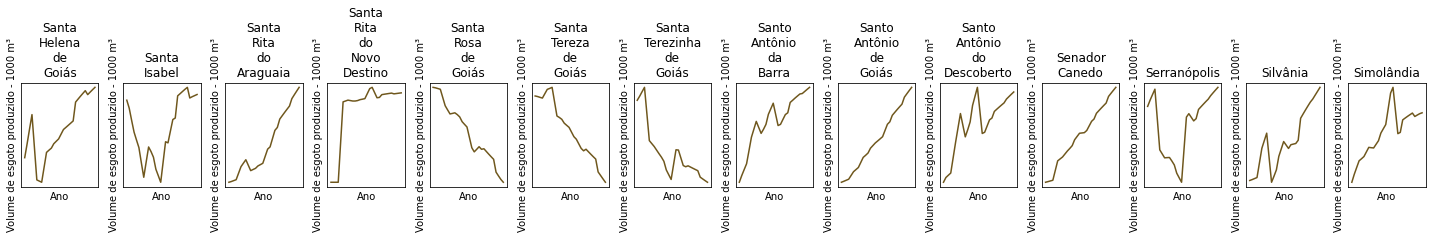

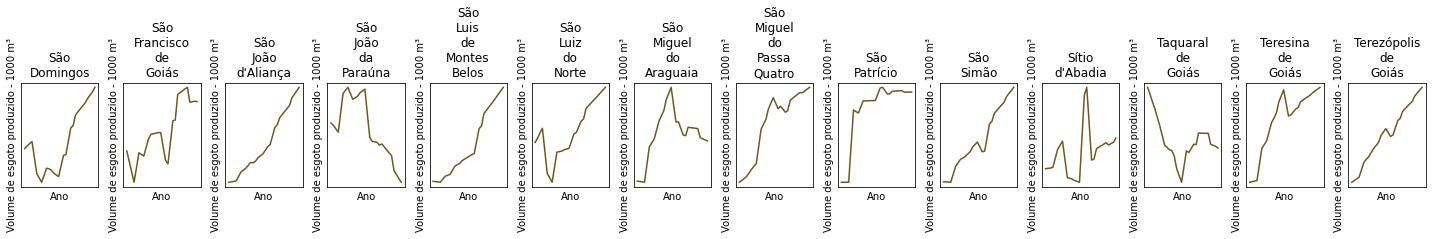

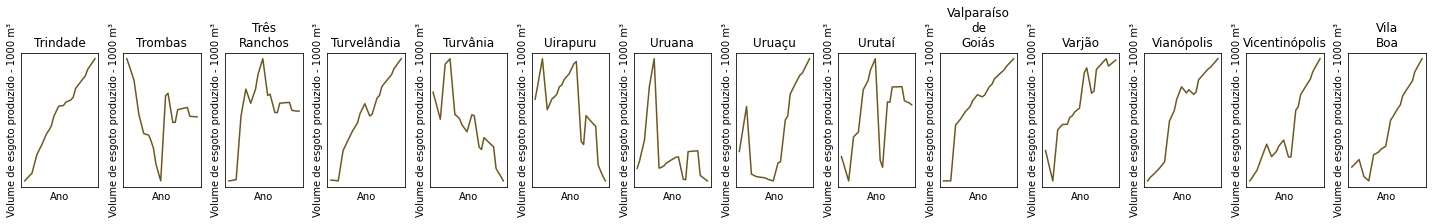

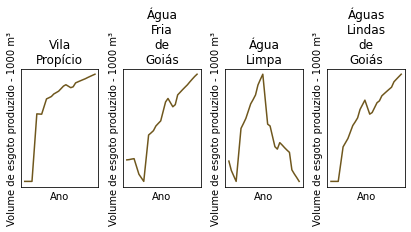

Cluster_produzido: 2


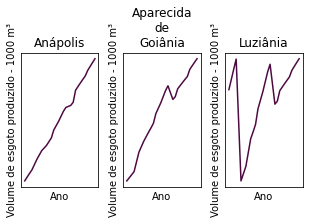

Cluster_produzido: 1


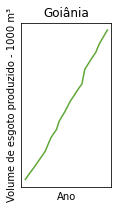

Clusterização: Volume de esgotos coletado - 1000 m³
Cluster_coletado: 0


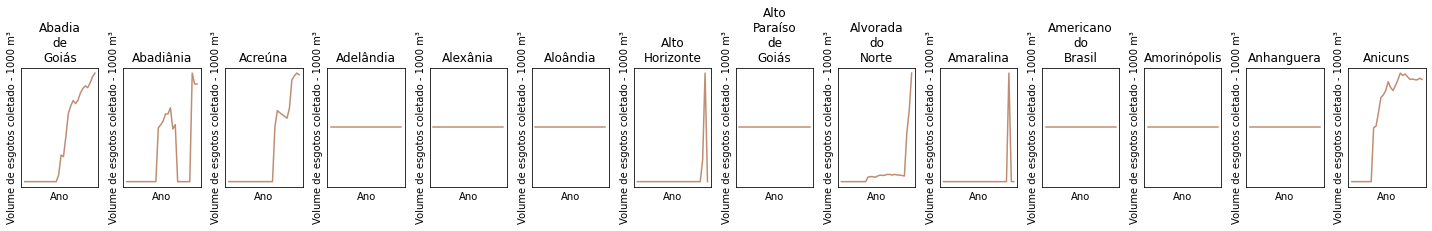

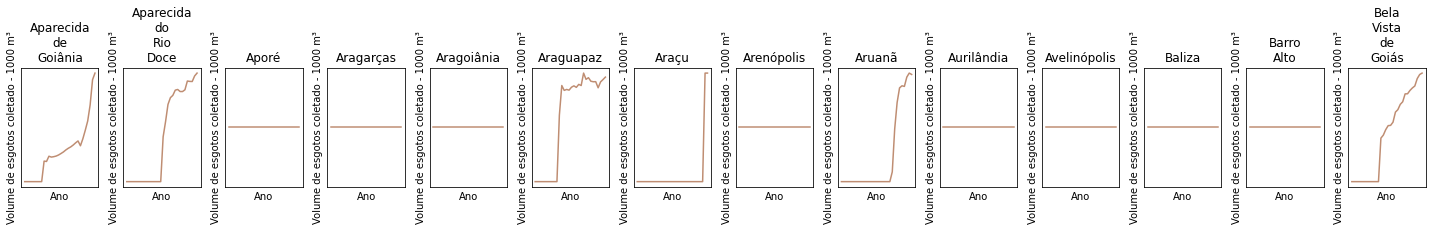

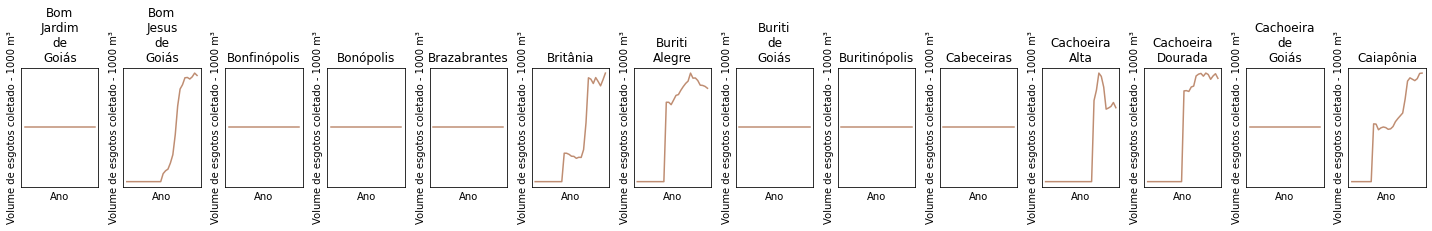

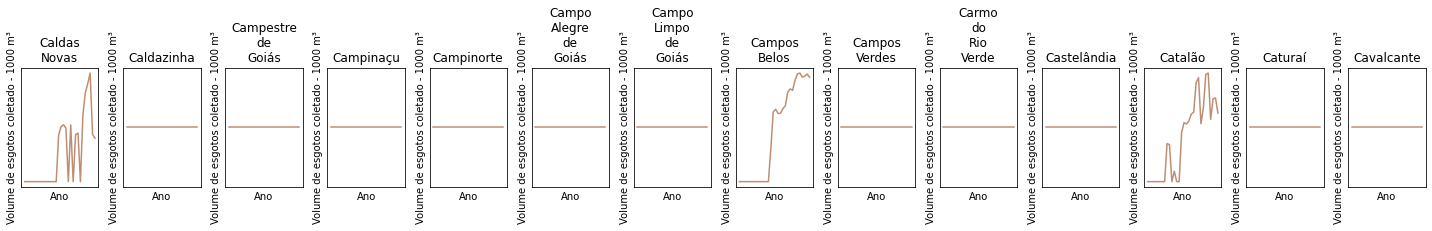

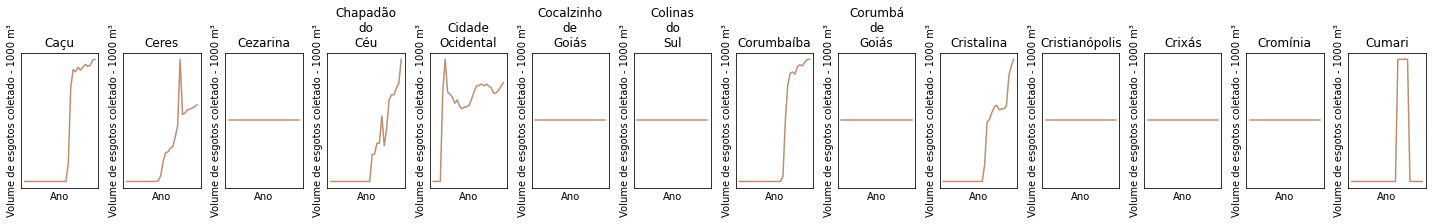

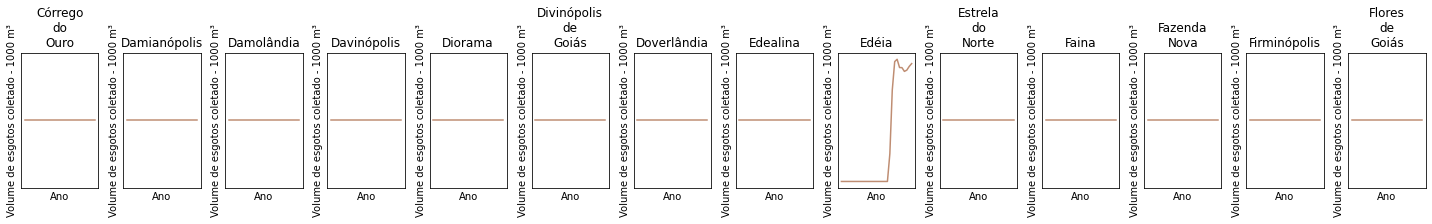

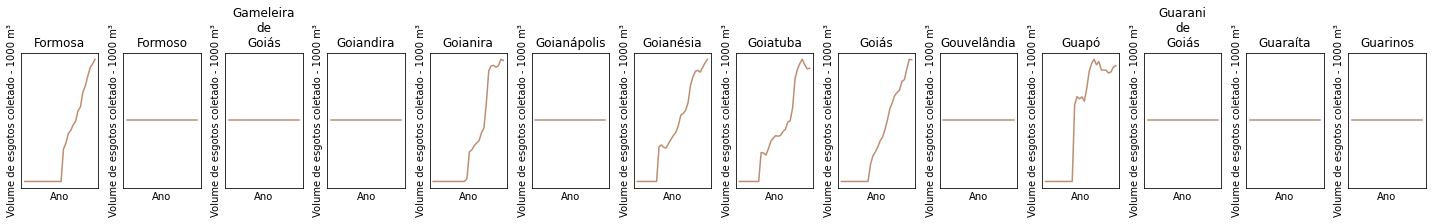

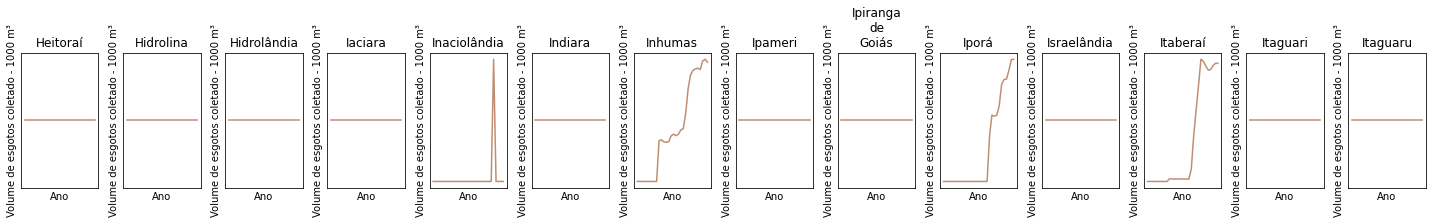

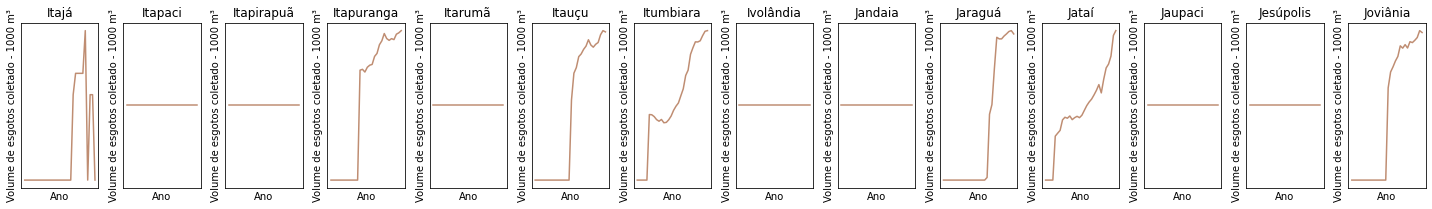

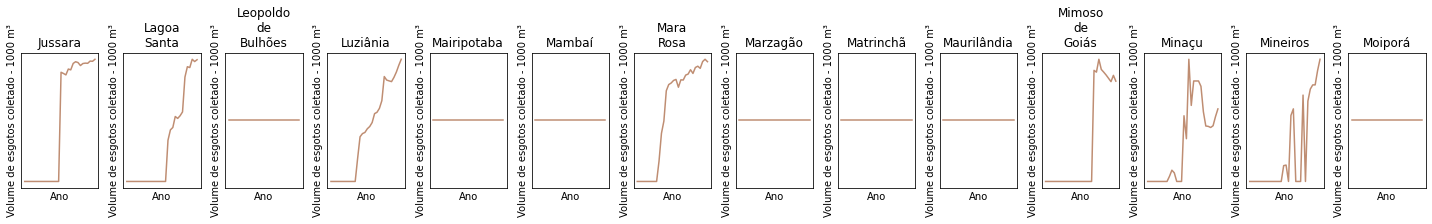

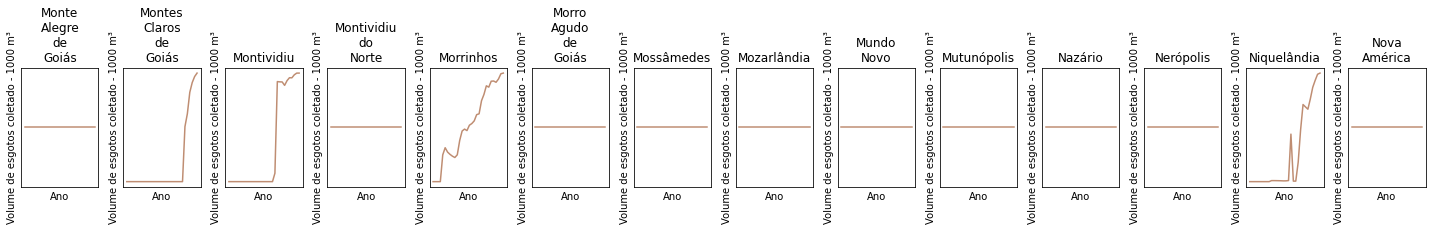

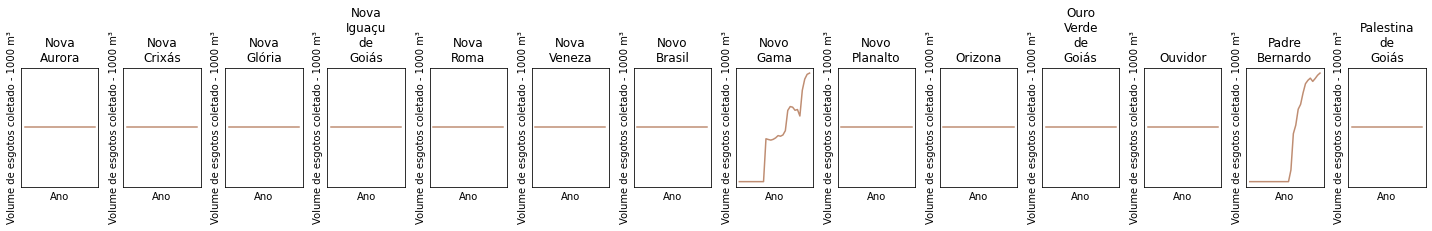

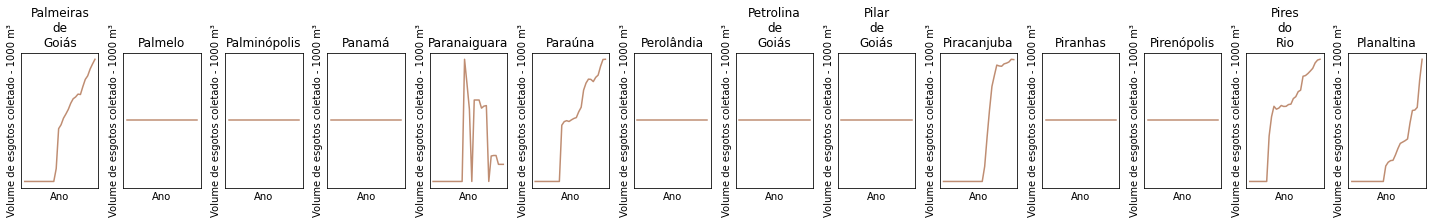

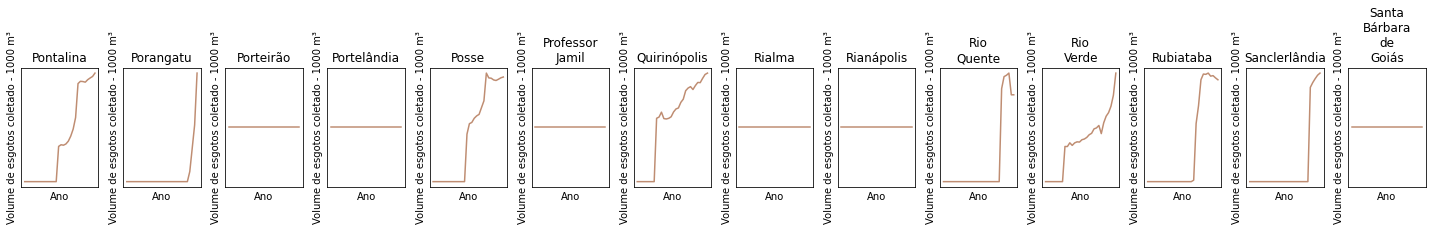

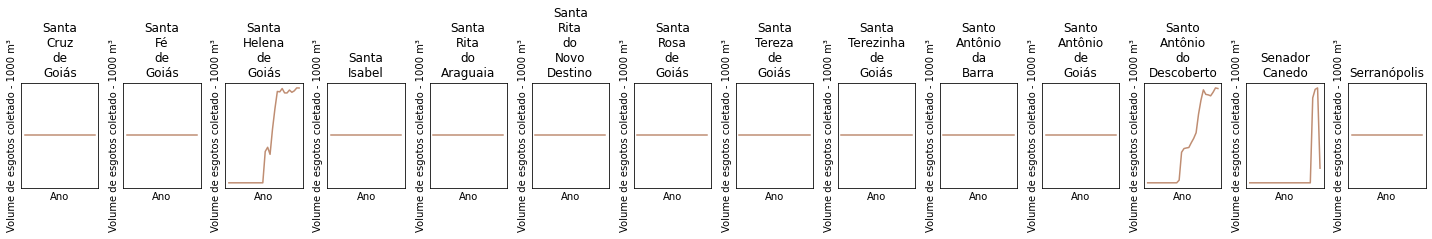

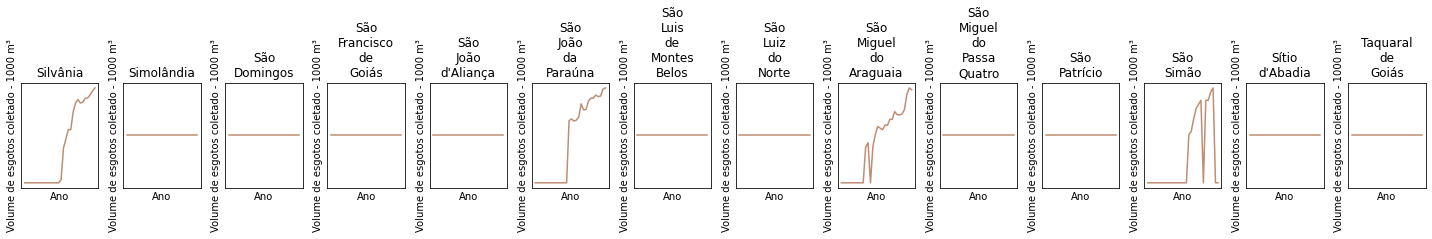

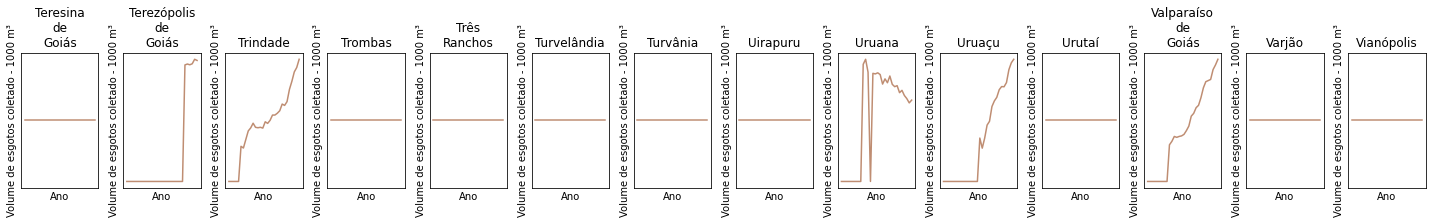

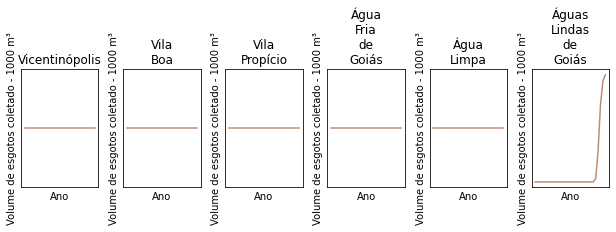

Cluster_coletado: 2


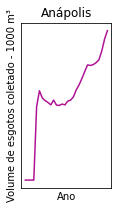

Cluster_coletado: 1


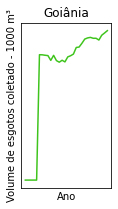

Clusterização: Volume de esgotos tratado - 1000 m³
Cluster_tratado: 0


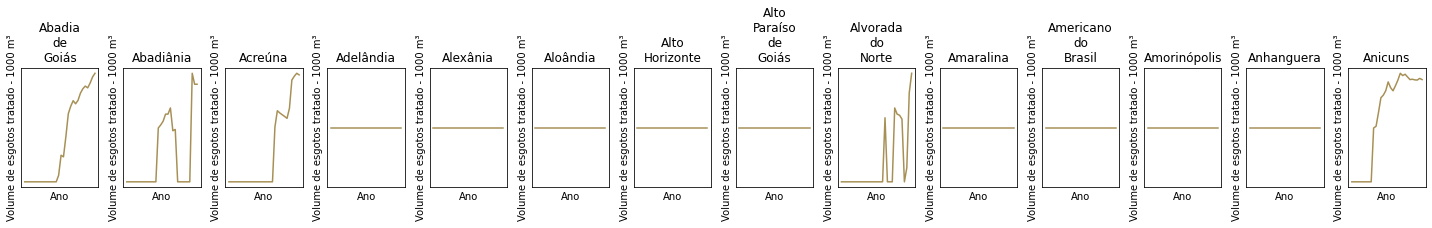

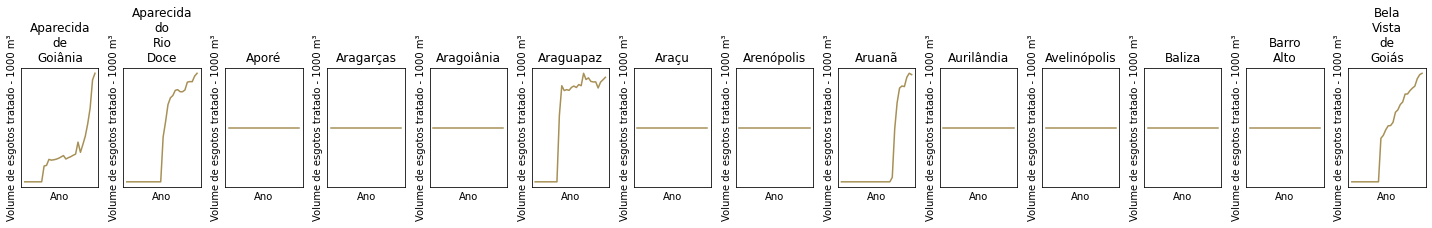

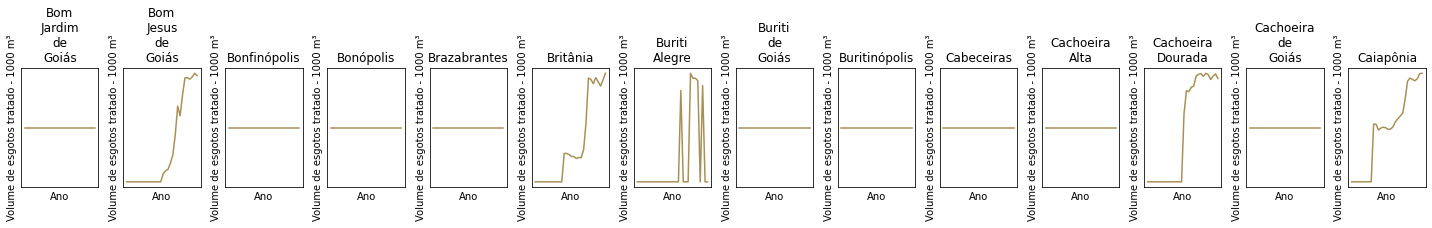

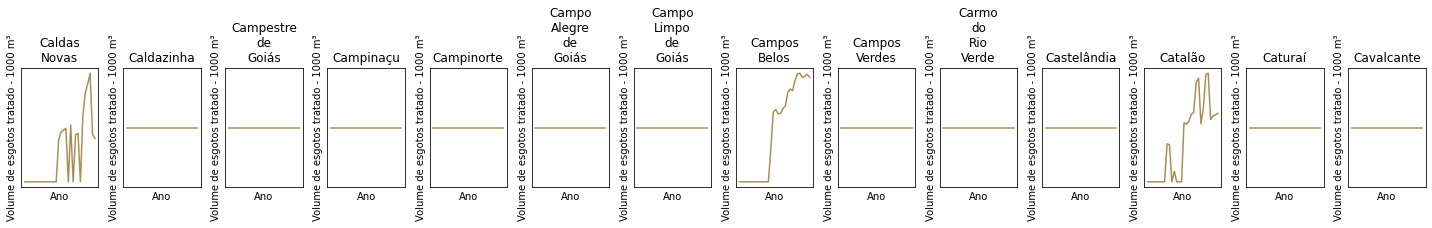

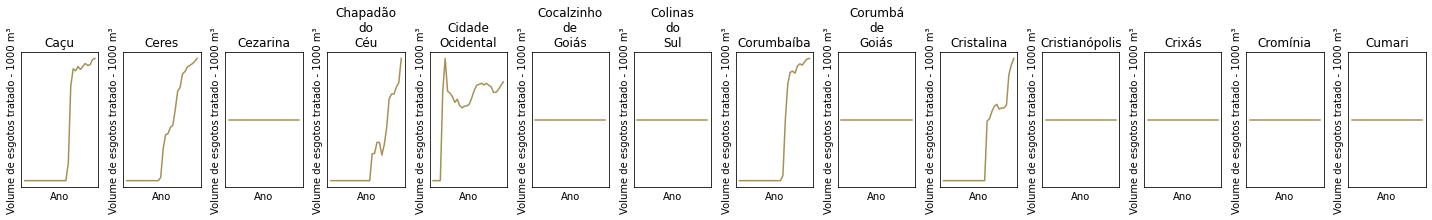

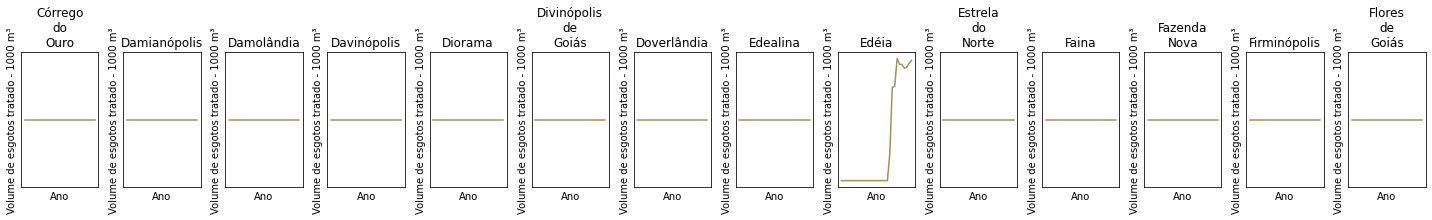

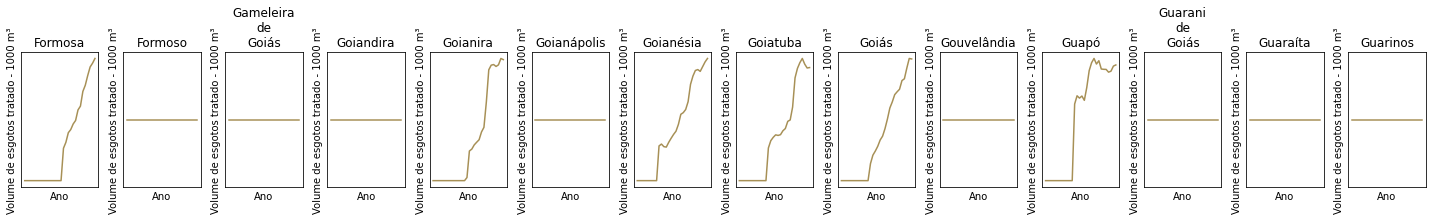

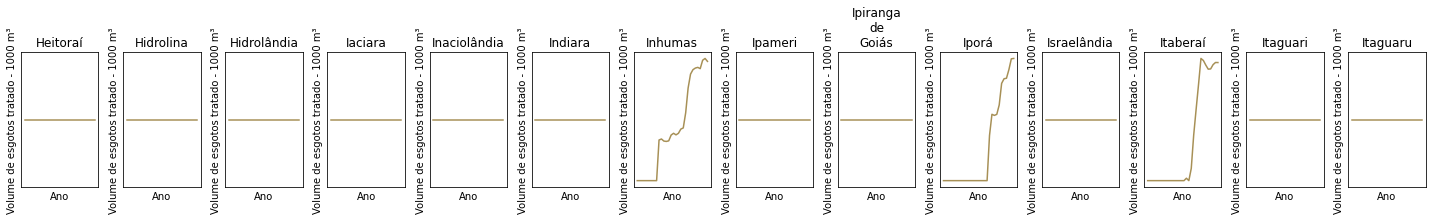

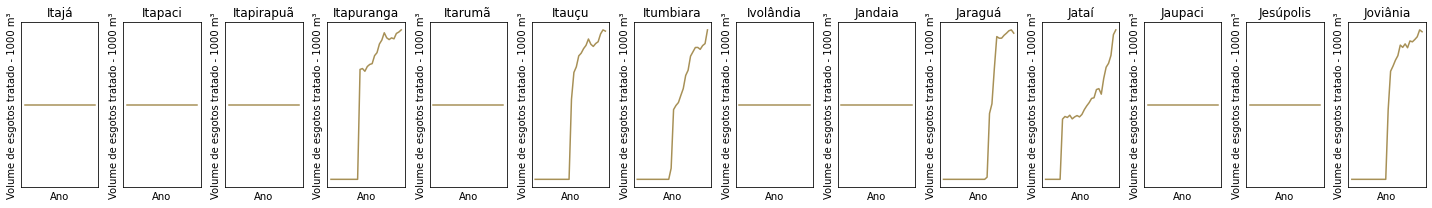

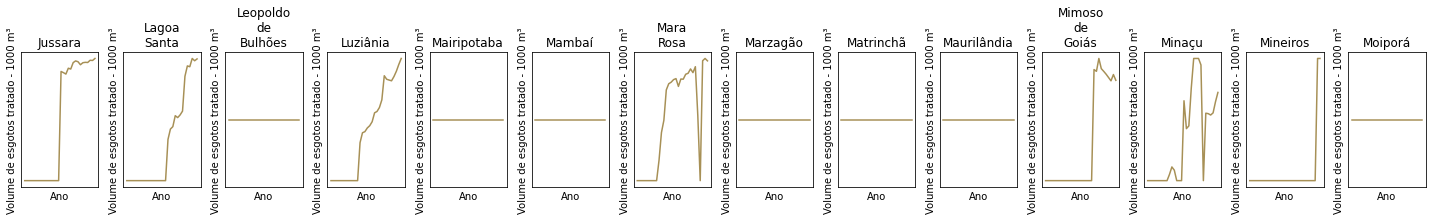

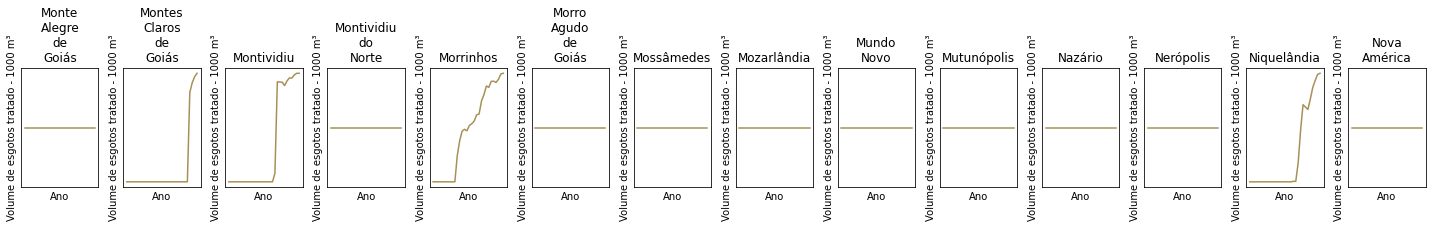

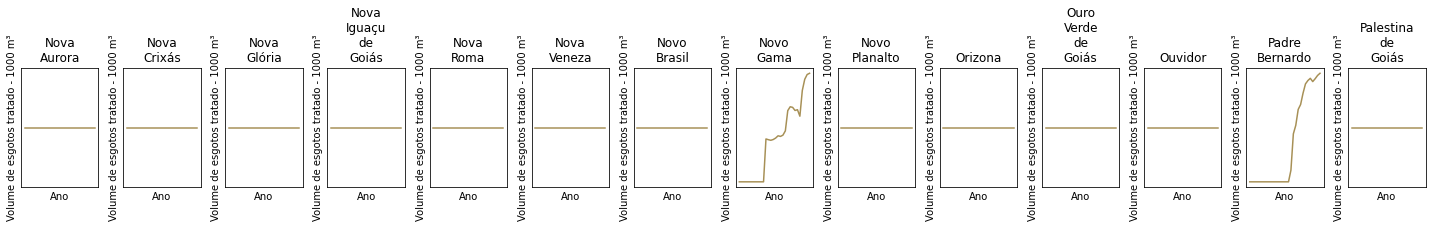

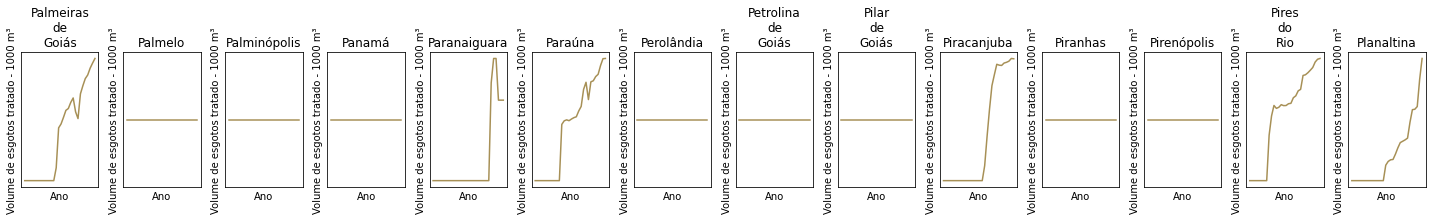

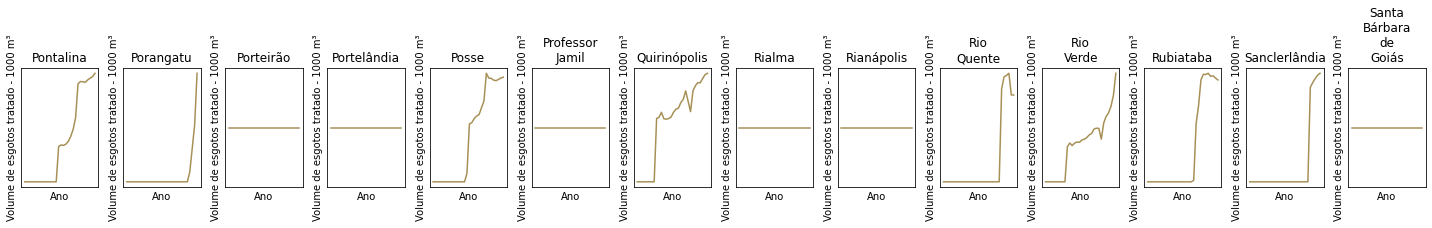

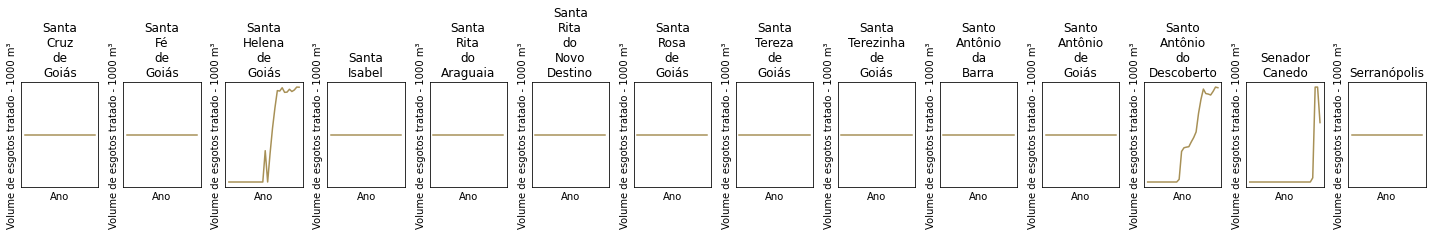

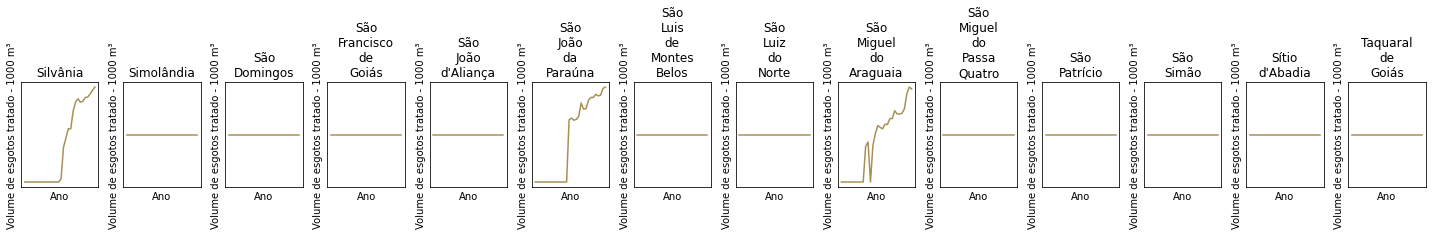

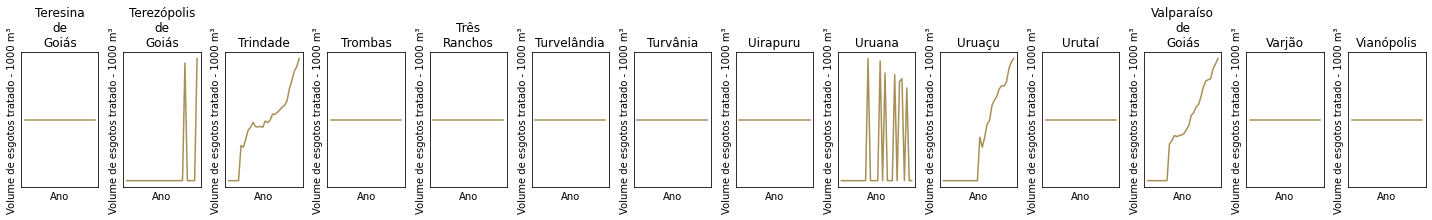

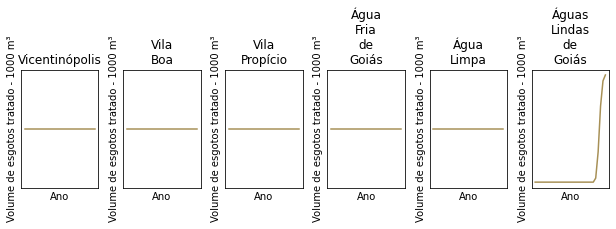

Cluster_tratado: 1


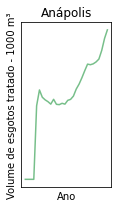

Cluster_tratado: 2


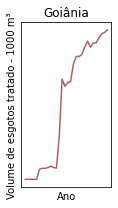

In [7]:
# Atribuindo o número de cluster que será aplicado ao modelo
# Este valor foi obtido por intermédio do por intermédio do Método Elbow Curve (método do cotovelo) 
clusters = 3


# Criando uma cópia do DataFrame df para que seja utilizado unicamente neste modelo
df_cluster = df.copy()

# Gerando a clusterização a partir do Modelo k-means
# Após a aplicação do modelo, será retornado diciniário com o valor do cluster de cada município
modelo_produzido = aplicar_modelo_kmeans(df_pivot_produzido, clusters)
modelo_coletado = aplicar_modelo_kmeans(df_pivot_coletado, clusters)
modelo_tratado = aplicar_modelo_kmeans(df_pivot_tratado, clusters)

# Gerando 3 novas colunas para armezenar o cluster de cada feature
df_cluster['Cluster_produzido'] = df_cluster['Município'].map(modelo_produzido)
df_cluster['Cluster_coletado'] = df_cluster['Município'].map(modelo_coletado)
df_cluster['Cluster_tratado'] = df_cluster['Município'].map(modelo_tratado)

# Estabelecendo a quantidade de gráficos que cada linha terá quando os dados forem plotados
linhas = 14

# Plotando o gráfico com os dados obtidos após a clusterização dos Municipíos
print('Clusterização: Volume de esgoto produzido - 1000 m³')
#Gráfico 1 - Clusterização dos municípios conforme a feature "Volume de esgoto produzido - 1000 m³"
plotar_graficos_multiplos(df_cluster, nome_coluna_municipio, nome_coluna_ano, 
                        nome_coluna_produzido, linhas, nome_coluna_cluster_produzido)

print('Clusterização: Volume de esgotos coletado - 1000 m³')
#Gráfico 2 - Clusterização dos municípios conforme a feature "Volume de esgotos coletado - 1000 m³"
plotar_graficos_multiplos(df_cluster, nome_coluna_municipio, nome_coluna_ano, 
                        nome_coluna_coletado, linhas, nome_coluna_cluster_coletado)

print('Clusterização: Volume de esgotos tratado - 1000 m³')
#Gráfico 3 - Clusterização dos municípios conforme a feature "Volume de esgotos tratado - 1000 m³'"
plotar_graficos_multiplos(df_cluster, nome_coluna_municipio, nome_coluna_ano, 
                        nome_coluna_tratado, linhas, nome_coluna_cluster_tratado)


In [8]:
# Verificando se a pasta "dados_GO/D - dado_predito/kmeans" já existe
if not os.path.exists('dados_GO/D - dado_predito/kmeans'):
    # Se não existir, cria a pasta
    os.makedirs('dados_GO/D - dado_predito/kmeans')

#Salvando o arquivo CSV no diretório "dados_GO/D - dado_predito/kmeans" como dados relativos à clusterização 
df_cluster.to_csv('dados_GO/D - dado_predito/kmeans/\
           df_predito_kmeans.csv', 
           index=False, sep=';')

#### 4 -  Aplicando Regressão Poliminal aos dados agrupados para o estado de Goiás

In [9]:
# Estabelecendo o número de dobras que será empregado na validação cruzada
cv = 5

# Aplicando o modelo de regressão poliminal em cada feature
desempenho_produzido = medir_desempenho_grau_regressao_polinomial(X1.values.reshape(-1, 1), y1, cv)
desempenho_coletado = medir_desempenho_grau_regressao_polinomial(X2.values.reshape(-1, 1), y2, cv)
desempenho_tratado = medir_desempenho_grau_regressao_polinomial(X2.values.reshape(-1, 1), y3, cv)

print('** Regressão Polinomial: Volume de esgoto produzido - 1000 m³ ** ')
tabela = [item.split(', ') for item in desempenho_produzido]
print(tabulate(tabela, tablefmt='fancy_grid'))
print('\n')

print('** Regressão Polinomial: Volume de esgotos coletado - 1000 m³ **')
tabela = [item.split(', ') for item in desempenho_coletado]
print(tabulate(tabela, tablefmt='fancy_grid'))
print('\n')

print('** Regressão Polinomial: Volume de esgotos tratado - 1000 m³ **')
tabela = [item.split(', ') for item in desempenho_tratado]
print(tabulate(tabela, tablefmt='fancy_grid'))

** Regressão Polinomial: Volume de esgoto produzido - 1000 m³ ** 
╒═════════╤══════════════════════════════════════════════╤═════════════╕
│ Grau:1  │ Raiz do Erro Quadrático Médio (RMSE):3306.11 │ R²:0.996375 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:2  │ Raiz do Erro Quadrático Médio (RMSE):3068.89 │ R²:0.997102 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:3  │ Raiz do Erro Quadrático Médio (RMSE):3648.3  │ R²:0.997205 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:4  │ Raiz do Erro Quadrático Médio (RMSE):3627.8  │ R²:0.997206 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:5  │ Raiz do Erro Quadrático Médio (RMSE):3607.22 │ R²:0.997207 │
├─────────┼──────────────────────────────────────────────┼─────────────┤
│ Grau:6  │ Raiz do Erro Quadrático Médio (RMSE):3586.77 │ R²:0.997208 │
├─────────┼──────────────────────────────────────────────┼

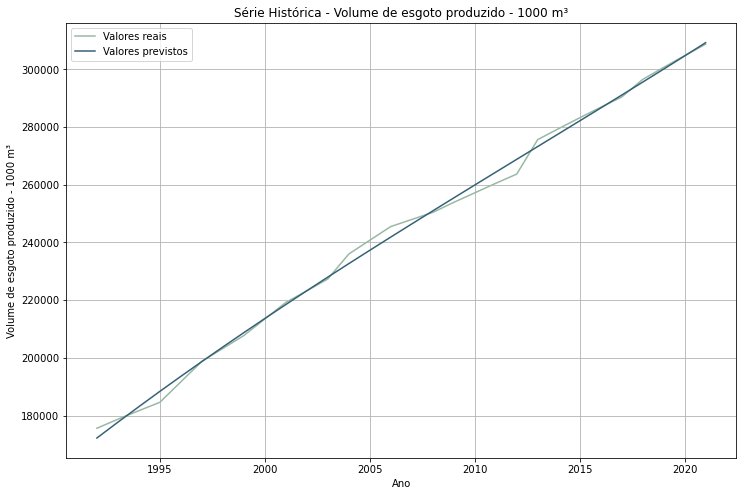

Não há diferença estatisticamente significativa (p_value:1.0)


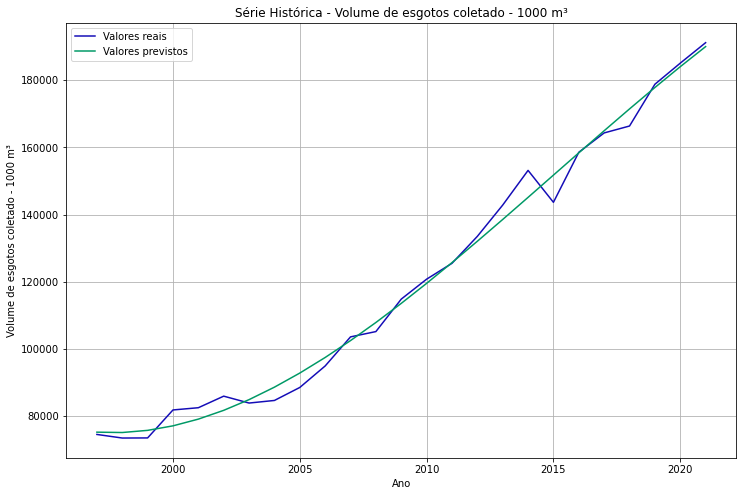

Não há diferença estatisticamente significativa (p_value:0.99999999)


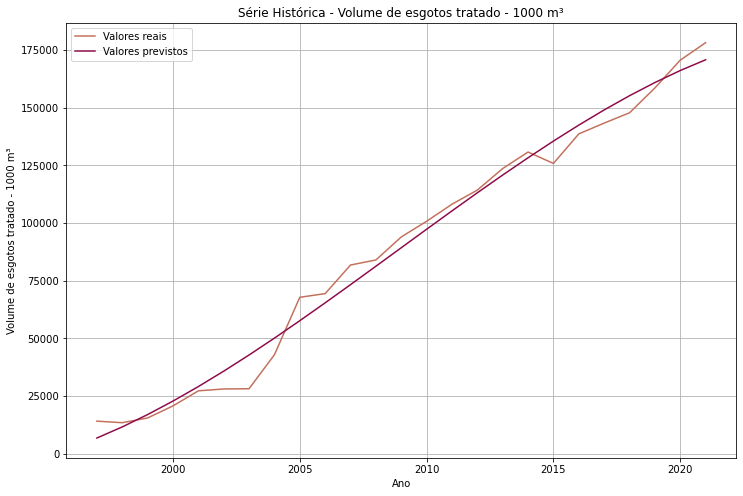

Não há diferença estatisticamente significativa (p_value:0.99999999)


In [10]:
# Atribuindo o valor do grau de cada modelo
# Este valor foi obtido por intermédio do por intermédio da função de avaliação de empenho
grau_produzido = 10
grau_coletado = 3
grau_tratado = 3

# Aplicando o modelo de regrassão polinomial aos dados
# Após a aplicação do modelo, serão retornados os valores preditos de teste
pred_y_poli_produzido, modelo_poli_produzido, feature_poli_produzido = aplicar_regressao_polinomial(X1, y1, 10)
pred_y_poli_coletado, modelo_poli_coletado, feature_poli_coletado = aplicar_regressao_polinomial(X2, y2, 3)
pred_y_poli_tratado, modelo_poli_tratado, feature_poli_tratado = aplicar_regressao_polinomial(X2, y3, 3)

# Criando duas cópias do DataFrame df para que sejam utilizados unicamente neste modelo
df_reg_poli_teste_prod = df_go.copy().drop(columns=["Volume de esgotos coletado - 1000 m³","Volume de esgotos tratado - 1000 m³"])
df_reg_poli_teste_prod['Volume de esgoto produzido - 1000 m³ (previsto em teste) '] = pred_y_poli_produzido
df_reg_poli_teste_col_trat = df_filtered.copy().drop(columns=["Volume de esgoto produzido - 1000 m³"])
df_reg_poli_teste_col_trat['Volume de esgoto coletado - 1000 m³ (previsto em teste)'] = pred_y_poli_coletado
df_reg_poli_teste_col_trat['Volume de esgoto tratado - 1000 m³ (previsto em teste)'] = pred_y_poli_tratado

# Plotando o gráfico com os dados reais e os dados preditos no teste e definindo o p_value
titulo_produzido = 'Série Histórica - '+ nome_coluna_produzido
titulo_coletado = 'Série Histórica - '+ nome_coluna_coletado
titulo_tratado = 'Série Histórica - '+ nome_coluna_tratado
label_real = 'Valores reais'
label_prev = 'Valores previstos'

plotar_unico_grafico_multi_curvas([X1, X1], [y1, pred_y_poli_produzido], 
                                  titulo_produzido, [label_real, label_prev], [nome_coluna_ano,nome_coluna_produzido])
calcular_p_value_alpha_05(X1.values, y1.values, pred_y_poli_produzido)
plotar_unico_grafico_multi_curvas([X2, X2], [y2, pred_y_poli_coletado], 
                                  titulo_coletado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_coletado])
calcular_p_value_alpha_05(X2.values, y2.values, pred_y_poli_coletado)
plotar_unico_grafico_multi_curvas([X2, X2], [y3, pred_y_poli_tratado], 
                                  titulo_tratado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_tratado])
calcular_p_value_alpha_05(X2.values, y3.values, pred_y_poli_tratado)

In [11]:
# Verificando se a pasta "dados_GO/D - dado_predito/regressao_polinomial/teste" já existe
if not os.path.exists('dados_GO/D - dado_predito/regressao_polinomial/teste'):
    # Se não existir, cria a pasta
    os.makedirs('dados_GO/D - dado_predito/regressao_polinomial/teste')

# Verificando se a pasta "dados_GO/D - dado_predito/regressao_polinomial/modelo" já existe
if not os.path.exists('dados_GO/D - dado_predito/regressao_polinomial/modelos'):
    # Se não existir, cria a pasta
    os.makedirs('dados_GO/D - dado_predito/regressao_polinomial/modelos')

#Salvando o arquivo CSV e o Modelo de Regressão no diretório "dados_GO/D - dado_predito/regressao_polinomial/teste/" 
#como dados relativos à clusterização 
df_reg_poli_teste_prod.to_csv('dados_GO/D - dado_predito/regressao_polinomial/teste/df_reg_poli_teste_prod.csv', 
                              index=False, sep=';')
df_reg_poli_teste_col_trat.to_csv('dados_GO/D - dado_predito/regressao_polinomial/teste/df_reg_poli_teste_col_trat.csv', 
                                  index=False, sep=';')

joblib.dump(modelo_poli_produzido, 'dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_produzido.pkl')
joblib.dump(modelo_poli_coletado, 'dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_coletado.pkl')
joblib.dump(modelo_poli_tratado, 'dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_tratado.pkl')

['dados_GO/D - dado_predito/regressao_polinomial/modelos/modelo_reg_poli_tratado.pkl']

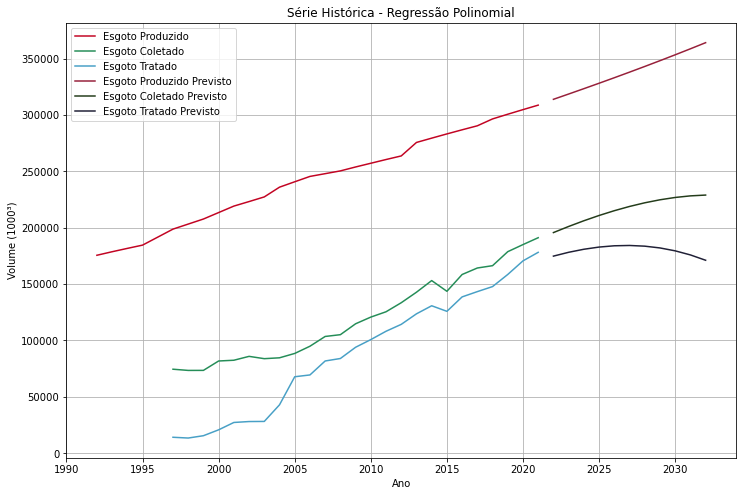

In [12]:
# Aplicando o modelo de regressão polinomial aos dados para predição dos anos 2022 a 2032
# Após a aplicação do modelo, serão retornados os valores preditos
y_pred_poli_futuro_produzido = modelo_poli_produzido.predict(feature_poli_produzido.transform(anos_futuros))
y_pred_poli_futuro_coletado = modelo_poli_coletado.predict(feature_poli_tratado.transform(anos_futuros))
y_pred_poli_futuro_tratado = modelo_poli_tratado.predict(feature_poli_coletado.transform(anos_futuros))

# Plotando o gráfico com os dados reais e os dados preditos
X_multi = [X1, X2, X2, anos_futuros, anos_futuros, anos_futuros]
y_multi = [y1, y2, y3, y_pred_poli_futuro_produzido, y_pred_poli_futuro_coletado, y_pred_poli_futuro_tratado]
titulo = 'Série Histórica - Regressão Polinomial'
label_real = ['Esgoto Produzido','Esgoto Coletado','Esgoto Tratado']
label_prev = ['Esgoto Produzido Previsto','Esgoto Coletado Previsto','Esgoto Tratado Previsto']
label_prev = label_real + label_prev
label_x = ['Ano']
label_y = ['Volume (1000³)']
label_eixos = label_x + label_y

plotar_unico_grafico_multi_curvas(X_multi, y_multi, titulo, label_prev, label_eixos)

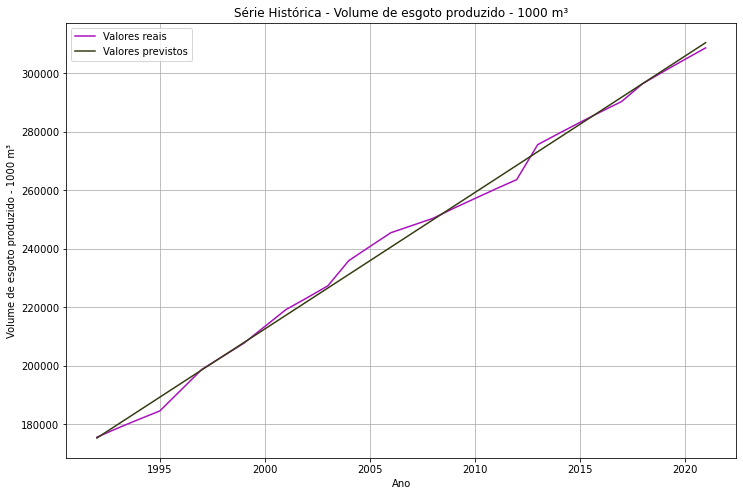

Não há diferença estatisticamente significativa (p_value:1.0)


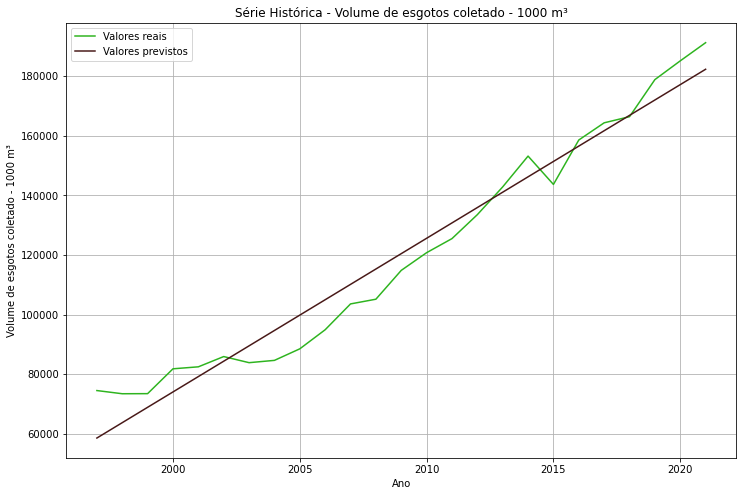

Não há diferença estatisticamente significativa (p_value:1.0)


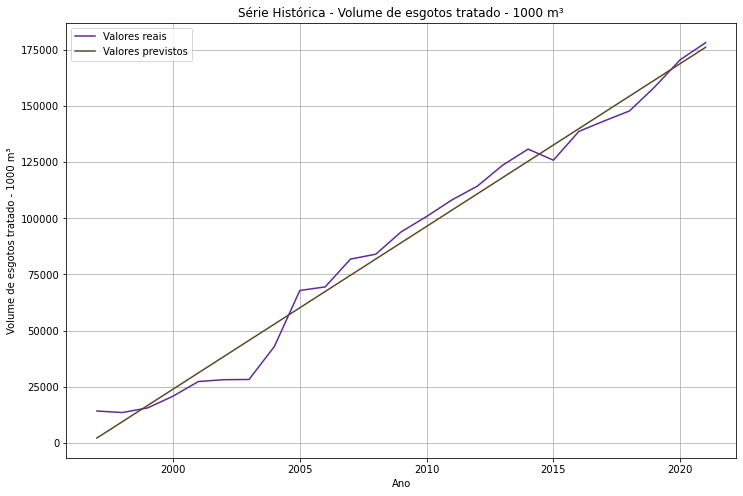

Não há diferença estatisticamente significativa (p_value:1.0)


Volume de esgoto produzido - 1000 m³
Raiz do Erro Quadrático Médio Médio (Cross-Validation): 3306.1087130919227
Coeficiente de Determinação (R²): 0.9964 

Volume de esgotos coletado - 1000 m³
Raiz do Erro Quadrático Médio Médio (Cross-Validation): 13026.674882040394
Coeficiente de Determinação (R²): 0.9624 

Volume de esgotos tratado - 1000 m³
Raiz do Erro Quadrático Médio Médio (Cross-Validation): 7795.133173668253
Coeficiente de Determinação (R²): 0.9846 



In [13]:
# Estabelecendo o número de dobras que será empregado na validação cruzada
cv = 5

# Aplicando o modelo de regressão lienar em cada feature
pred_y_linear_produzido, modelo_linear_produzido, eqm_linear_produzido, r2_lienar_produzido =\
aplicar_regressao_linear(X1, y1, cv)
pred_y_linear_coletado, modelo_linear_coletado, eqm_linear_coletado, r2_lienar_coletado =\
aplicar_regressao_linear(X2, y2, cv)
pred_y_linear_tratado, modelo_linear_tratado, eqm_linear_tratado, r2_lienar_tratado =\
aplicar_regressao_linear(X2, y3, cv)


# Plotando o gráfico com os dados reais e os dados preditos no teste e definindo o p_value
titulo_produzido = 'Série Histórica - '+ nome_coluna_produzido
titulo_coletado = 'Série Histórica - '+ nome_coluna_coletado
titulo_tratado = 'Série Histórica - '+ nome_coluna_tratado
label_real = 'Valores reais'
label_prev = 'Valores previstos'

plotar_unico_grafico_multi_curvas([X1, X1], [y1, pred_y_linear_produzido], 
                                  titulo_produzido, [label_real, label_prev], [nome_coluna_ano,nome_coluna_produzido])
calcular_p_value_alpha_05(X1.values, y1.values, pred_y_linear_produzido)
plotar_unico_grafico_multi_curvas([X2, X2], [y2, pred_y_linear_coletado], 
                                  titulo_coletado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_coletado])
calcular_p_value_alpha_05(X2.values, y2.values, pred_y_linear_coletado)
plotar_unico_grafico_multi_curvas([X2, X2], [y3, pred_y_linear_tratado], 
                                  titulo_tratado, [label_real, label_prev], [nome_coluna_ano,nome_coluna_tratado])
calcular_p_value_alpha_05(X2.values, y3.values, pred_y_linear_tratado)

# Imprimendo as variáveis do modelo
print('\n')
print(nome_coluna_produzido)
print(f'Raiz do Erro Quadrático Médio Médio (Cross-Validation): {np.sqrt(eqm_linear_produzido)}')
print(f'Coeficiente de Determinação (R²): {r2_lienar_produzido.round(4)} \n')
print(nome_coluna_coletado)
print(f'Raiz do Erro Quadrático Médio Médio (Cross-Validation): {np.sqrt(eqm_linear_coletado)}')
print(f'Coeficiente de Determinação (R²): {r2_lienar_coletado.round(4)} \n')
print(nome_coluna_tratado)
print(f'Raiz do Erro Quadrático Médio Médio (Cross-Validation): {np.sqrt(eqm_linear_tratado)}')
print(f'Coeficiente de Determinação (R²): {r2_lienar_tratado.round(4)} \n')

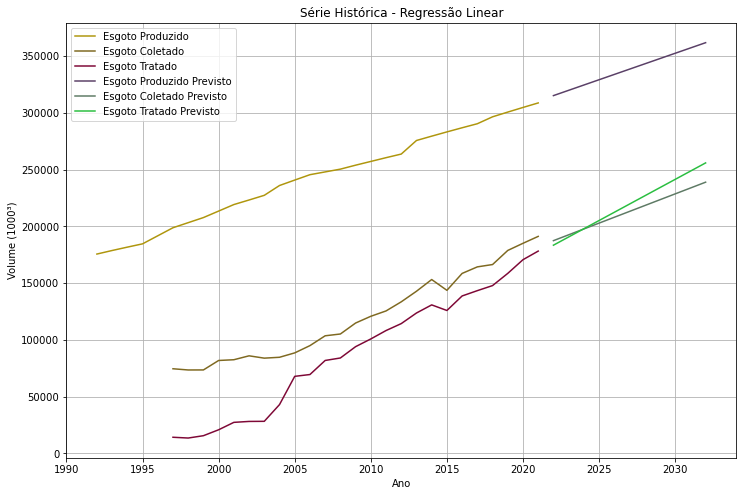

In [14]:
# Aplicando o modelo de regressão linear aos dados para predição dos anos 2022 a 2032
# Após a aplicação do modelo, serão retornados os valores preditos
y_pred_futuro_lienar_produzido = modelo_linear_produzido.predict(anos_futuros)
y_pred_futuro_linear_coletado = modelo_linear_coletado.predict(anos_futuros)
y_pred_futuro_linear_tratado = modelo_linear_tratado.predict(anos_futuros)


# Plotando o gráfico com os dados reais e os dados preditos
X_multi = [X1, X2, X2, anos_futuros, anos_futuros, anos_futuros]
y_multi = [y1, y2, y3, y_pred_futuro_lienar_produzido, y_pred_futuro_linear_coletado, y_pred_futuro_linear_tratado]
titulo = 'Série Histórica - Regressão Linear'
label_real = ['Esgoto Produzido','Esgoto Coletado','Esgoto Tratado']
label_prev = ['Esgoto Produzido Previsto','Esgoto Coletado Previsto','Esgoto Tratado Previsto']
label_prev = label_real + label_prev
label_x = ['Ano']
label_y = ['Volume (1000³)']
label_eixos = label_x + label_y

plotar_unico_grafico_multi_curvas(X_multi, y_multi, titulo, label_prev, label_eixos)

In [15]:
dic_verificacao_coletado_tratado = {'Ano': anos_futuros.flatten(), 
        'Volume de Esgoto Coletado': y_pred_futuro_linear_coletado, 
        'Volume de Esgoto Tratado': y_pred_futuro_linear_tratado}
df_verificacao_coletado_tratado = pd.DataFrame(dic_verificacao_coletado_tratado)
df_verificacao_coletado_tratado

print('*** Ano em que todo o esgoto coletado estará sendo tratado: ***')
df_verificacao_coletado_tratado[df_verificacao_coletado_tratado['Volume de Esgoto Tratado'] 
                                >= df_verificacao_coletado_tratado['Volume de Esgoto Coletado']].head(1)

*** Ano em que todo o esgoto coletado estará sendo tratado: ***


,Ano,Volume de Esgoto Coletado,Volume de Esgoto Tratado
2,2024,197698.964885,197889.496592


In [16]:
# Aplicando o modelo de regrassão linear aos dados para predição dos anos 2022 a 2032
# Após a aplicação do modelo, serão retornados os valores preditos
desempenho_arima_produzido = medir_desempenho_ARIMA(X1,y1, range(0, 2), range(0, 2), range(0, 4))
desempenho_arima_coletado = medir_desempenho_ARIMA(X2,y2)
desempenho_arima_tratado = medir_desempenho_ARIMA(X2,y3)

print('** Modelo ARIMA: Volume de esgoto produzido - 1000 m³ ** ')
tabela = [item.split(', ') for item in desempenho_arima_produzido]
print(tabulate(tabela, tablefmt='fancy_grid'))
print('\n')

print('** Modelo ARIMA: Volume de esgotos coletado - 1000 m³ **')
tabela = [item.split(', ') for item in desempenho_arima_coletado]
print(tabulate(tabela, tablefmt='fancy_grid'))
print('\n')

print('** Modelo ARIMA: Volume de esgotos tratado - 1000 m³ **')
tabela = [item.split(', ') for item in desempenho_arima_tratado]
print(tabulate(tabela, tablefmt='fancy_grid'))

** Modelo ARIMA: Volume de esgoto produzido - 1000 m³ ** 
╒═════════════════╤═════════════╤═════════════════════════════════════════╤══════════════════════════════════════════════╕
│ (p=0; d=0; q=0) │ AIC: 653.33 │ Raiz do Erro Quadrático Médio: 50206.94 │ Coeficiente de Determinação (R²): -61.187856 │
├─────────────────┼─────────────┼─────────────────────────────────────────┼──────────────────────────────────────────────┤
│ (p=0; d=0; q=1) │ AIC: 570.15 │ Raiz do Erro Quadrático Médio: 47912.41 │ Coeficiente de Determinação (R²): -55.2265   │
├─────────────────┼─────────────┼─────────────────────────────────────────┼──────────────────────────────────────────────┤
│ (p=0; d=0; q=2) │ AIC: 570.29 │ Raiz do Erro Quadrático Médio: 45808.38 │ Coeficiente de Determinação (R²): -50.311329 │
├─────────────────┼─────────────┼─────────────────────────────────────────┼──────────────────────────────────────────────┤
│ (p=0; d=0; q=3) │ AIC: 575.86 │ Raiz do Erro Quadrático Médio: 44056.3  │ Coefi

In [17]:
# Verificando se a pasta "dados_GO/D - dado_predito/regressao_polinomial/teste" já existe
if not os.path.exists('dados_GO/D - dado_predito/ARIMA/modelo'):
    # Se não existir, cria a pasta
    os.makedirs('dados_GO/D - dado_predito/ARIMA/modelo')


joblib.dump(desempenho_arima_produzido, 'dados_GO/D - dado_predito/ARIMA/modelo/modelo_arima_produzido.pkl')
joblib.dump(modelo_poli_coletado, 'dados_GO/D - dado_predito/ARIMA/modelo/modelo_arima_coletado.pkl')
joblib.dump(desempenho_arima_tratado, 'dados_GO/D - dado_predito/ARIMA/modelo/modelo_arima_tratado.pkl')

['dados_GO/D - dado_predito/ARIMA/modelo/modelo_arima_tratado.pkl']